# Feature and HP selection

In [1]:
import gc
import gzip
import os
import warnings
from collections import defaultdict
from copy import deepcopy
from dataclasses import dataclass
from itertools import chain
from os.path import join
from typing import Dict, List, Union

import Bio
import Bio.PDB
import Bio.SeqRecord
import PIL
import shap
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from boruta import BorutaPy
from geometricus import Geometricus, ShapemerLearn
from IPython.display import clear_output
from lightgbm import LGBMClassifier
from scipy.stats import kstest, mannwhitneyu, shapiro, ttest_ind
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, silhouette_score, ConfusionMatrixDisplay
from sklearn.model_selection import (BaseCrossValidator, KFold, cross_validate,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from statsmodels.stats.multitest import multipletests
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [2]:
# Set up data dir
DATA_FOLDER = "."
features_path = join(DATA_FOLDER, "Features.csv")

# Some random things
SEED = 10101
np.random.seed(SEED)
torch.manual_seed(SEED)

# Matplotlib settings
plt.rcParams["figure.figsize"] = 10, 7
plt.rcParams["font.size"] = 16

n_jobs = 16
alpha = 0.05

## EDA

Будем работать с данными и димерах, выложенных в базы данных структур. Некоторые из них являются артефактами пробоподготовки (и по сути зря лежат в базах). Можем попробовать научить модель классифицировать такие белки (`physiological`: `True` / `False`). Ниже пара примеров.

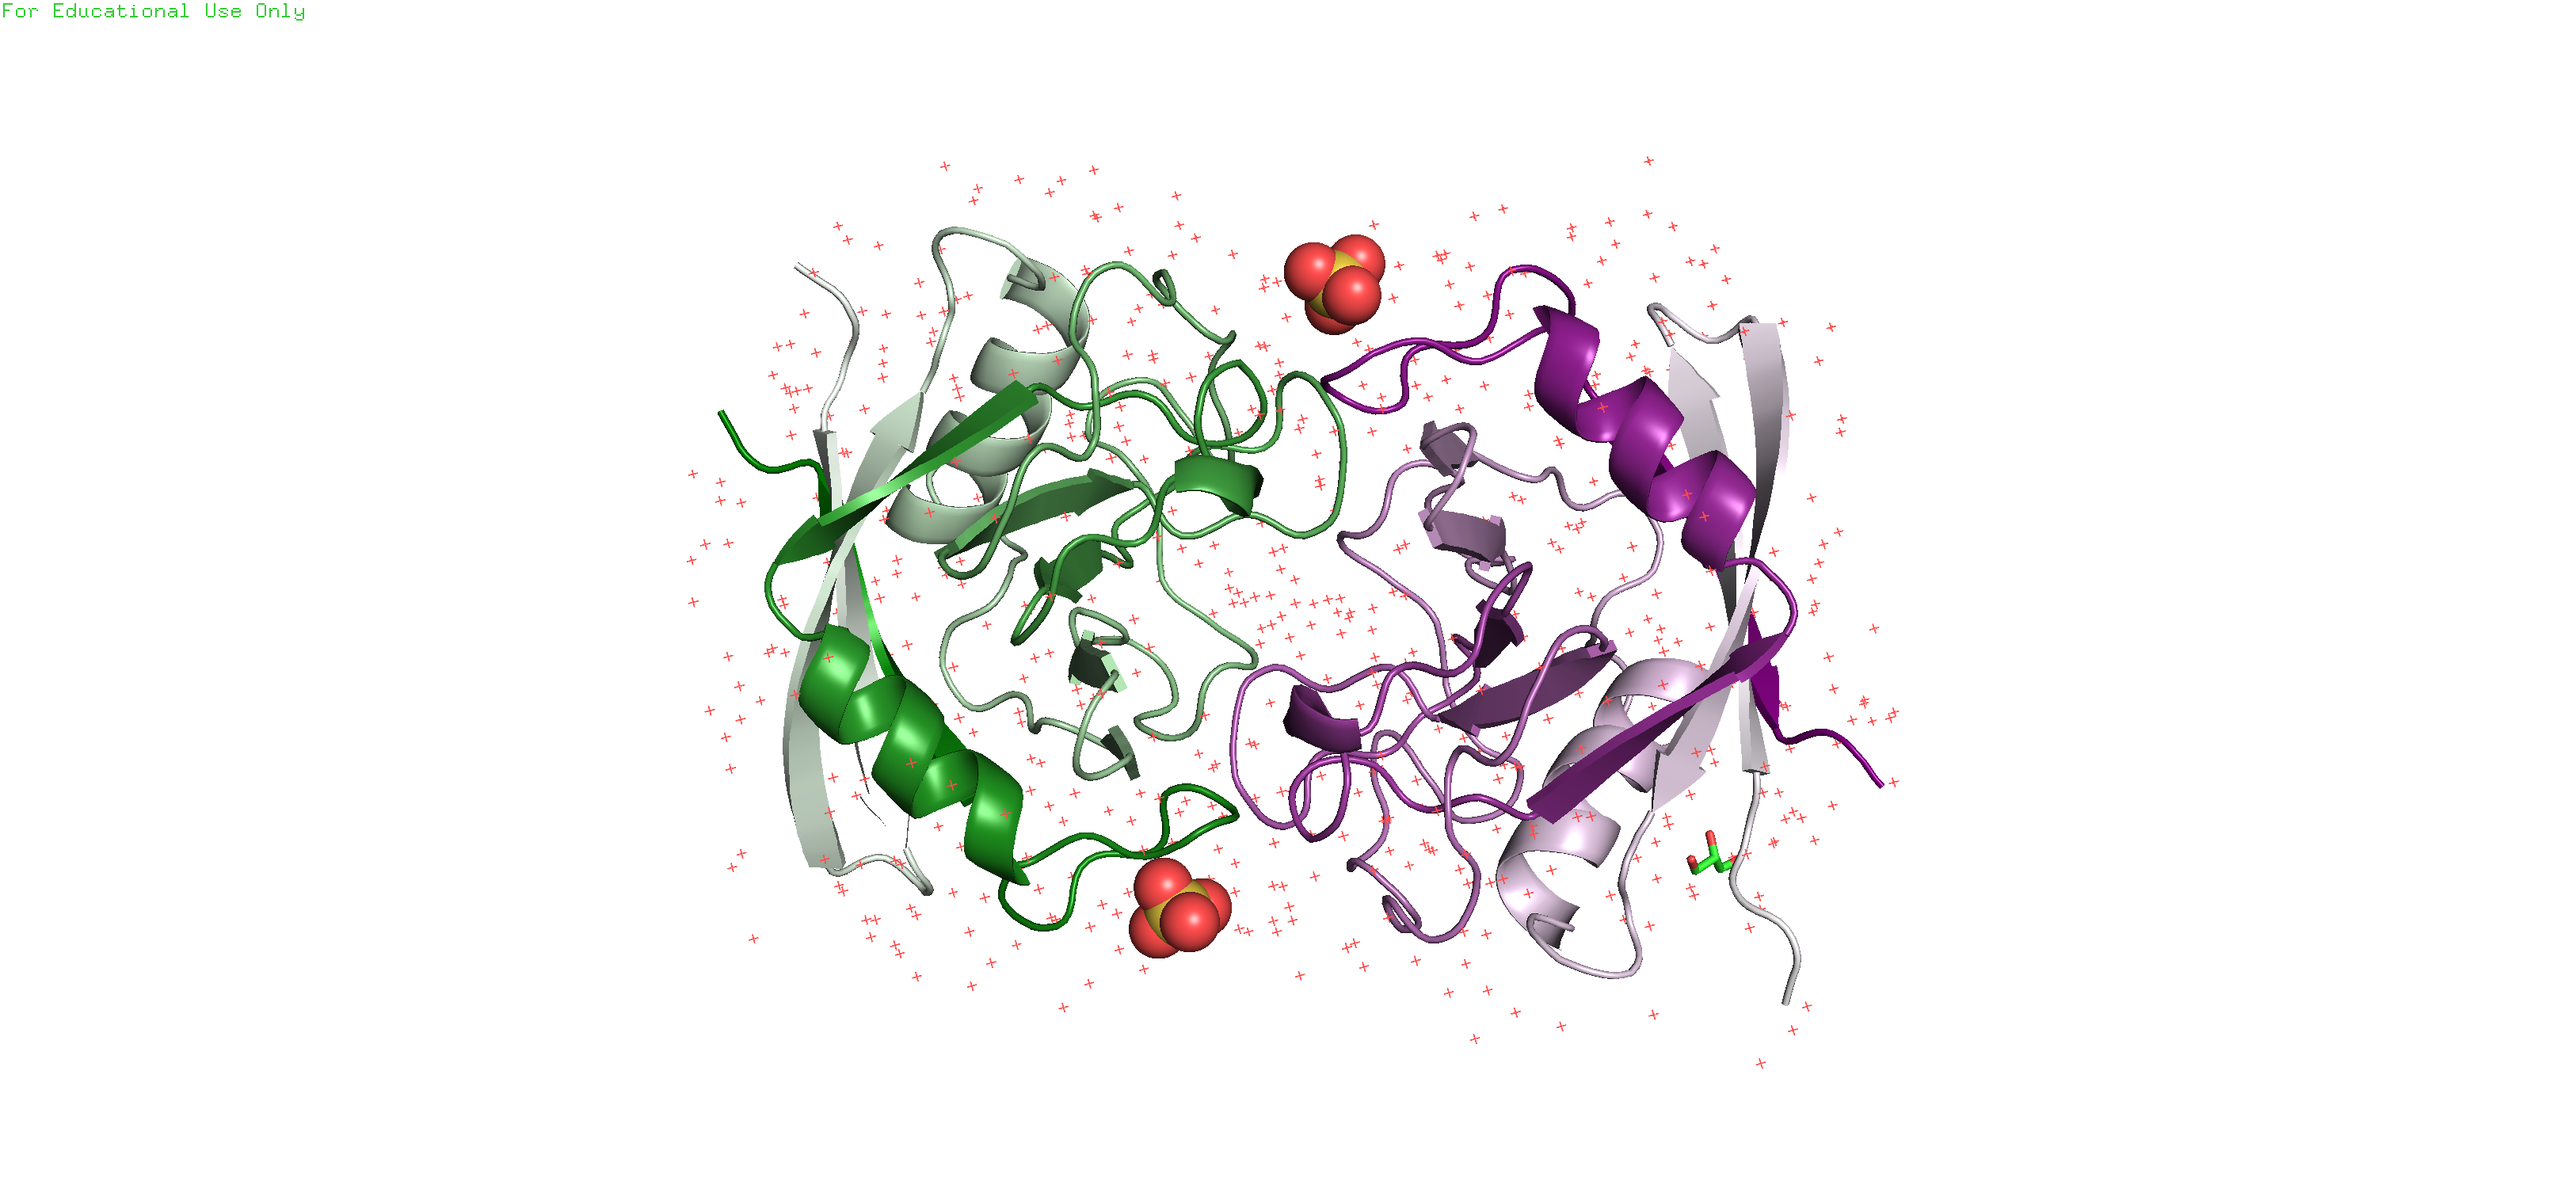

In [3]:
PIL.Image.open("images/2x2a_1_dt_pt.png")

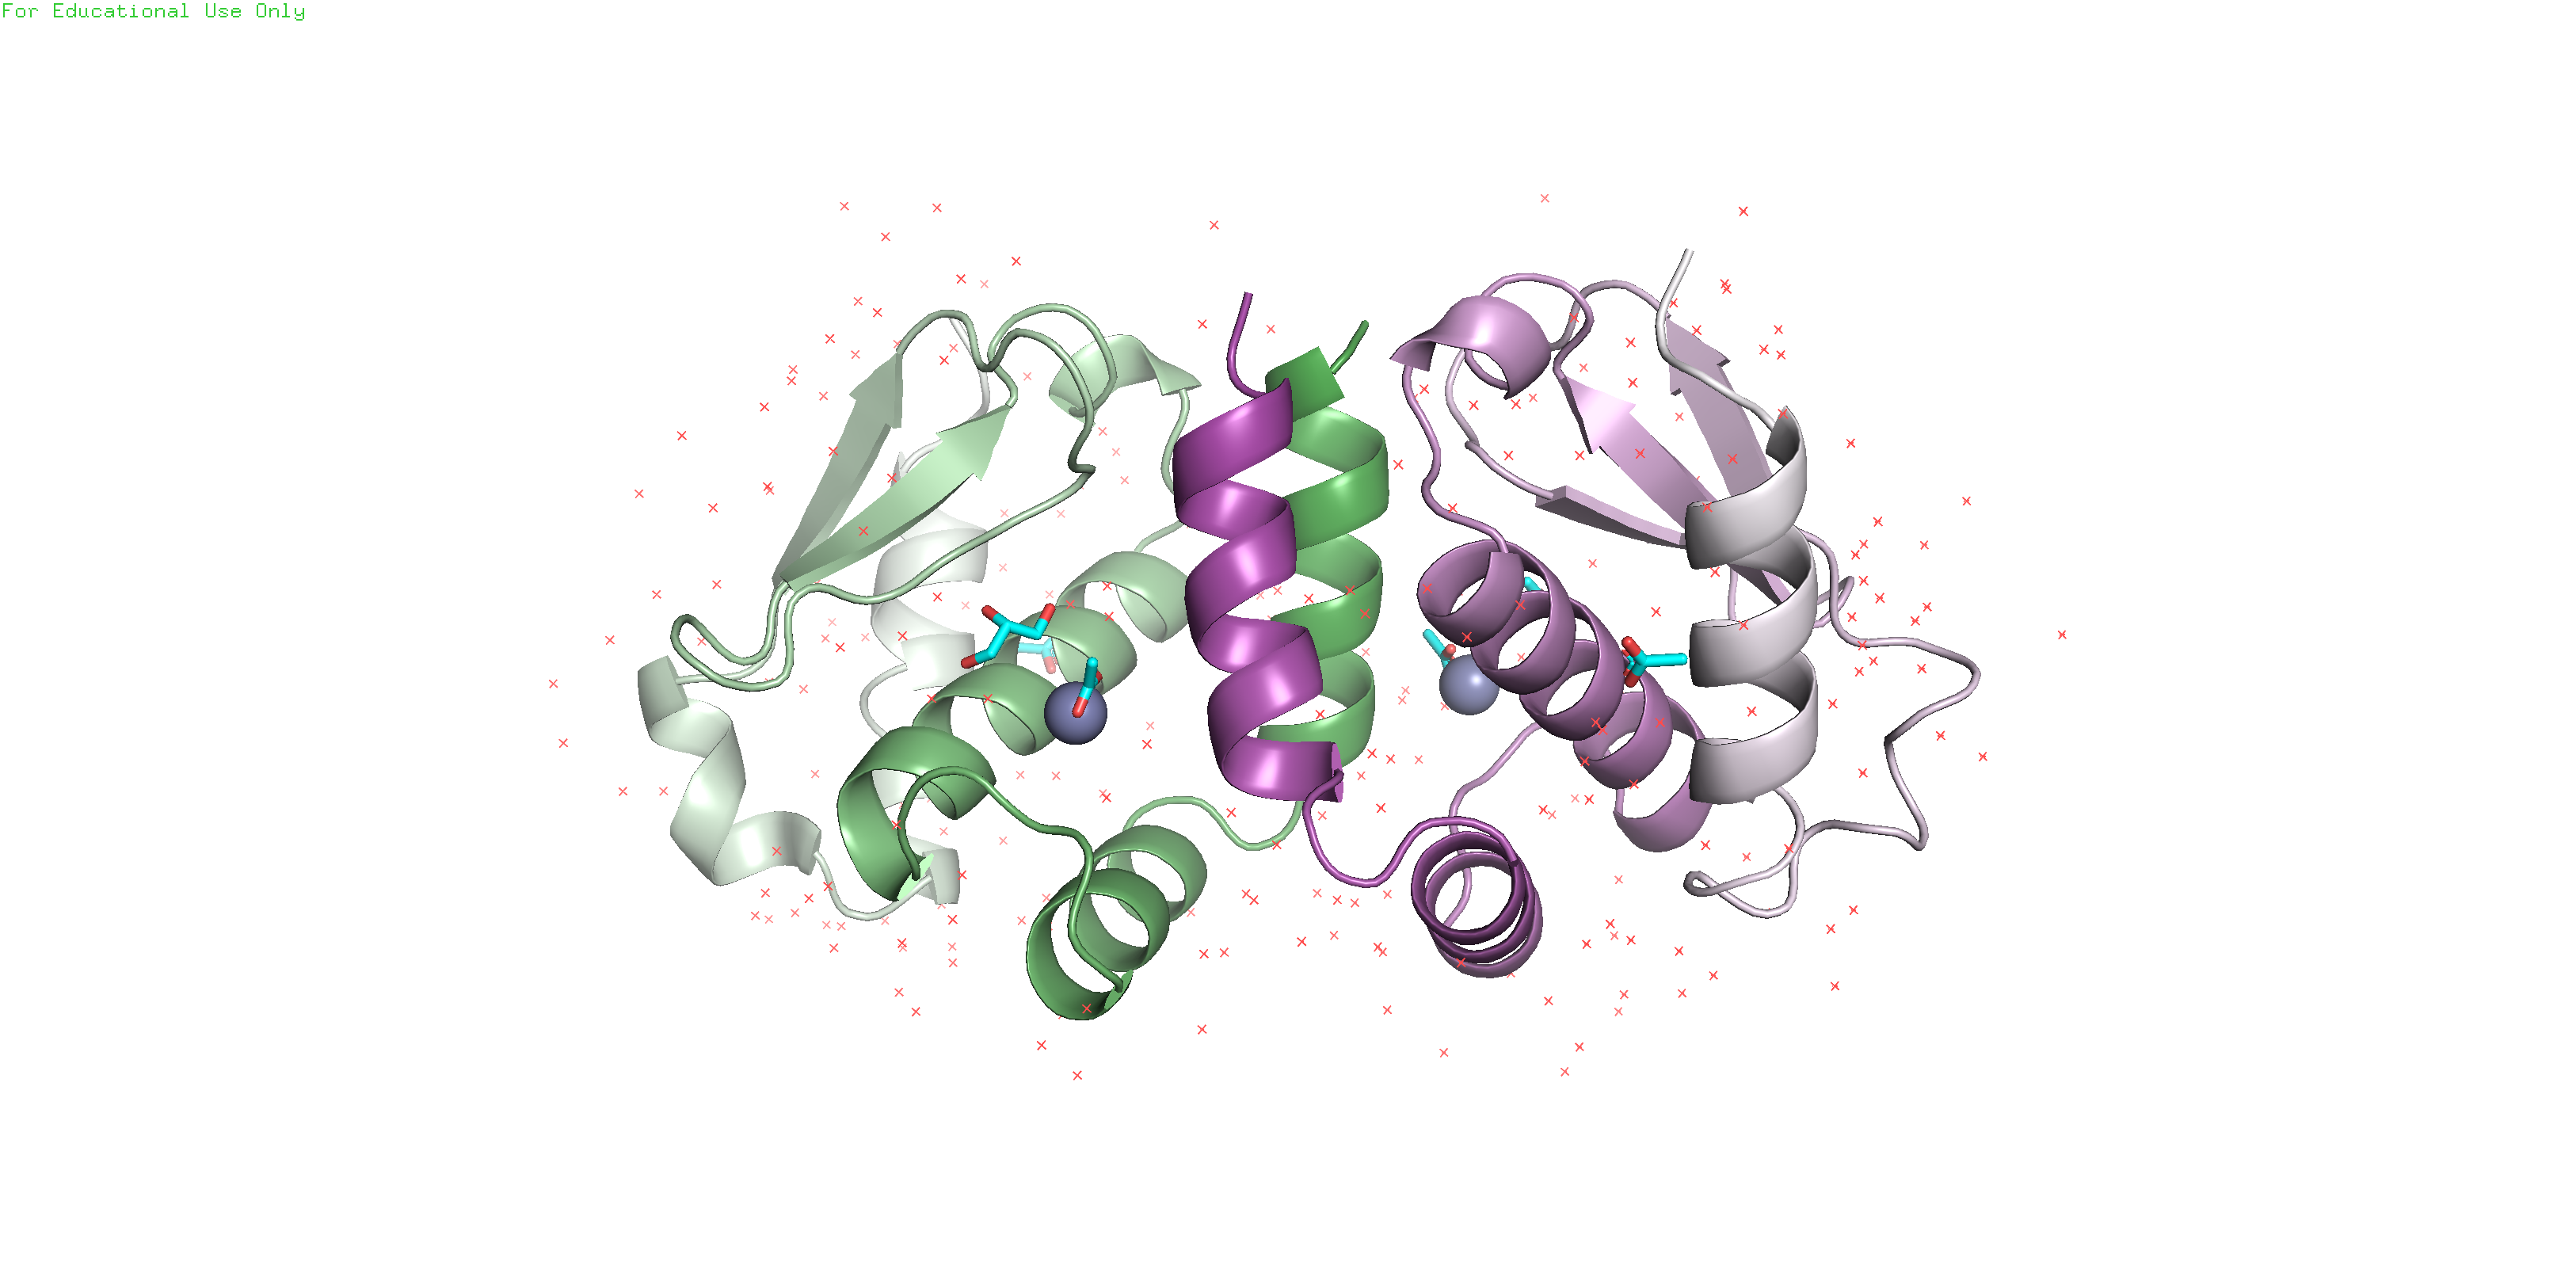

In [4]:
PIL.Image.open("images/4qhj_1_dt_pf.png")

In [5]:
features = pd.read_csv(features_path, index_col=0)
features.head()

pdb-id  global_area  global_area_per_atom  global_volume  \
0  1a17_6      33290.7              12.99403        63046.7   
1  1a3a_1      27576.3              12.20190        54497.2   
2  1a7g_1      16535.3              12.56482        32323.4   
3  1ac6_1      20742.3              12.13000        41277.9   
4  1afw_1      65759.5              11.19501       133638.0   

   global_volume_per_atom  global_energy  global_energy_per_atom  \
0                24.60839       -6364.07                -2.48402   
1                24.11381       -7467.66                -3.30427   
2                24.56185       -3276.97                -2.49010   
3                24.13912       -5331.03                -3.11756   
4                22.75077      -16828.70                -2.86495   

   global_sas_area  global_sas_area_per_atom  global_sas_energy  ...  \
0         17047.60                   6.65402          -1801.530  ...   
1         12863.40                   5.69177          -1617.510  ...   
2          8715.92                   6.62304            371.893  ...   
3         10556.20                   6.17322           -802.868  ...   
4         25731.70                   4.38061          -1377.680  ...   

   contacts      gene  superfamily             pfam  binding_site_area  \
0       138     PPP5C   1.25.40.10              NaN            4153.16   
1        62      mtlA  3.40.930.10          PF00359            1868.68   
2        72        E2  3.30.70.330          PF00511            1849.89   
3        43  TRAV6D-7   2.60.40.10          PF07686            1196.80   
4       196      POT1   3.40.47.10  PF00108;PF02803            4846.12   

   binding_site_area_polar  binding_site_area_apolar  fraction_polar  \
0                  1651.43                   2501.74        0.397632   
1                   826.64                   1042.03        0.442366   
2                   694.27                   1155.61        0.375303   
3                   452.58                    744.22        0.378158   
4                  1860.29                   2985.83        0.383872   

   fraction_apolar  difficult  
0         0.602370      False  
1         0.557629      False  
2         0.624691      False  
3         0.621842      False  
4         0.616128      False  

[5 rows x 68 columns]

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1677 entries, 0 to 1676
Data columns (total 68 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   pdb-id                                      1677 non-null   object 
 1   global_area                                 1677 non-null   float64
 2   global_area_per_atom                        1677 non-null   float64
 3   global_volume                               1677 non-null   float64
 4   global_volume_per_atom                      1677 non-null   float64
 5   global_energy                               1677 non-null   float64
 6   global_energy_per_atom                      1677 non-null   float64
 7   global_sas_area                             1677 non-null   float64
 8   global_sas_area_per_atom                    1677 non-null   float64
 9   global_sas_energy                           1677 non-null   float64
 10  global_sas_e

In [7]:
num_features = [col for col in features.columns if features[col].dtype in ["float64", "int64"]]
cat_features = [col for col in features.columns if features[col].dtype == "object"]
all_features = num_features + cat_features

target_col = "physiological"
difficult_col = "difficult"

# Check that we didn't lose any columns
assert len(num_features) + len(cat_features) + 2 == features.shape[1]

In [8]:
features.duplicated().sum()

0

In [9]:
number_of_nas = features.isna().sum()
number_of_nas[number_of_nas != 0]

SymmetryOp1    977
SymmetryOp2    977
gene           149
superfamily    248
pfam           105
dtype: int64

### Числовые признаки

Явно признаки имеют довольно сильный разброс. Поэтому важно сделать нормализацию, если захочется использовать модели, для которых это важно (напр., логистическая регрессия).

In [10]:
features[num_features].describe()

global_area  global_area_per_atom  global_volume  \
count    1677.000000           1677.000000    1677.000000   
mean    52768.881783             12.360047  105075.918664   
std     36437.257310              0.641412   73436.446318   
min      6897.220000             10.865950   12938.800000   
25%     28419.800000             11.949140   55961.200000   
50%     43620.000000             12.274470   86753.300000   
75%     64717.300000             12.678650  129622.000000   
max    339825.000000             15.898130  695671.000000   

       global_volume_per_atom  global_energy  global_energy_per_atom  \
count             1677.000000    1677.000000             1677.000000   
mean                24.452683  -11664.144638               -2.669201   
std                  0.864757    8558.617395                0.522487   
min                 21.314060  -77460.800000               -4.183390   
25%                 23.914480  -14929.500000               -3.008060   
50%                 24.400120   -9586.390000               -2.730590   
75%                 24.908710   -5939.520000               -2.413960   
max                 28.590370     373.905000                0.387070   

       global_sas_area  global_sas_area_per_atom  global_sas_energy  \
count      1677.000000               1677.000000        1677.000000   
mean      25004.102332                  6.054914        -221.461894   
std       16425.605416                  0.870026        1847.709523   
min        4543.150000                  4.131220       -8390.950000   
25%       14271.000000                  5.476980       -1092.330000   
50%       21053.700000                  5.969730        -275.557000   
75%       29824.600000                  6.497040         587.326000   
max      143703.000000                 10.609110       15872.900000   

       global_sas_energy_per_atom  ...  difference_nonsas_area  \
count                 1677.000000  ...             1677.000000   
mean                    -0.037757  ...              851.383292   
std                      0.419732  ...              404.742019   
min                     -1.574820  ...               42.900000   
25%                     -0.307130  ...              586.800000   
50%                     -0.079320  ...              789.900000   
75%                      0.179290  ...             1011.900000   
max                      2.192090  ...             3795.200000   

       difference_nonsas_area_per_atom  difference_nonsas_energy  \
count                      1677.000000               1677.000000   
mean                          0.261006               -360.760152   
std                           0.175960                260.395264   
min                           0.003040              -2016.340000   
25%                           0.152500               -469.160000   
50%                           0.217660               -327.682000   
75%                           0.314590               -190.960000   
max                           1.723520                254.270000   

       difference_nonsas_energy_per_atom     contacts  binding_site_area  \
count                        1677.000000  1677.000000        1677.000000   
mean                           -0.126877    72.198569        2273.567168   
std                             0.131500    42.249704        1084.389361   
min                            -1.096030     1.000000         100.620000   
25%                            -0.160820    49.000000        1612.790000   
50%                            -0.094160    65.000000        2097.570000   
75%                            -0.045330    83.000000        2646.310000   
max                             0.053640   663.000000       10984.550000   

       binding_site_area_polar  binding_site_area_apolar  fraction_polar  \
count              1677.000000               1677.000000     1677.000000   
mean                873.091532               1396.858002        0.382493   
std                 472.235174                701

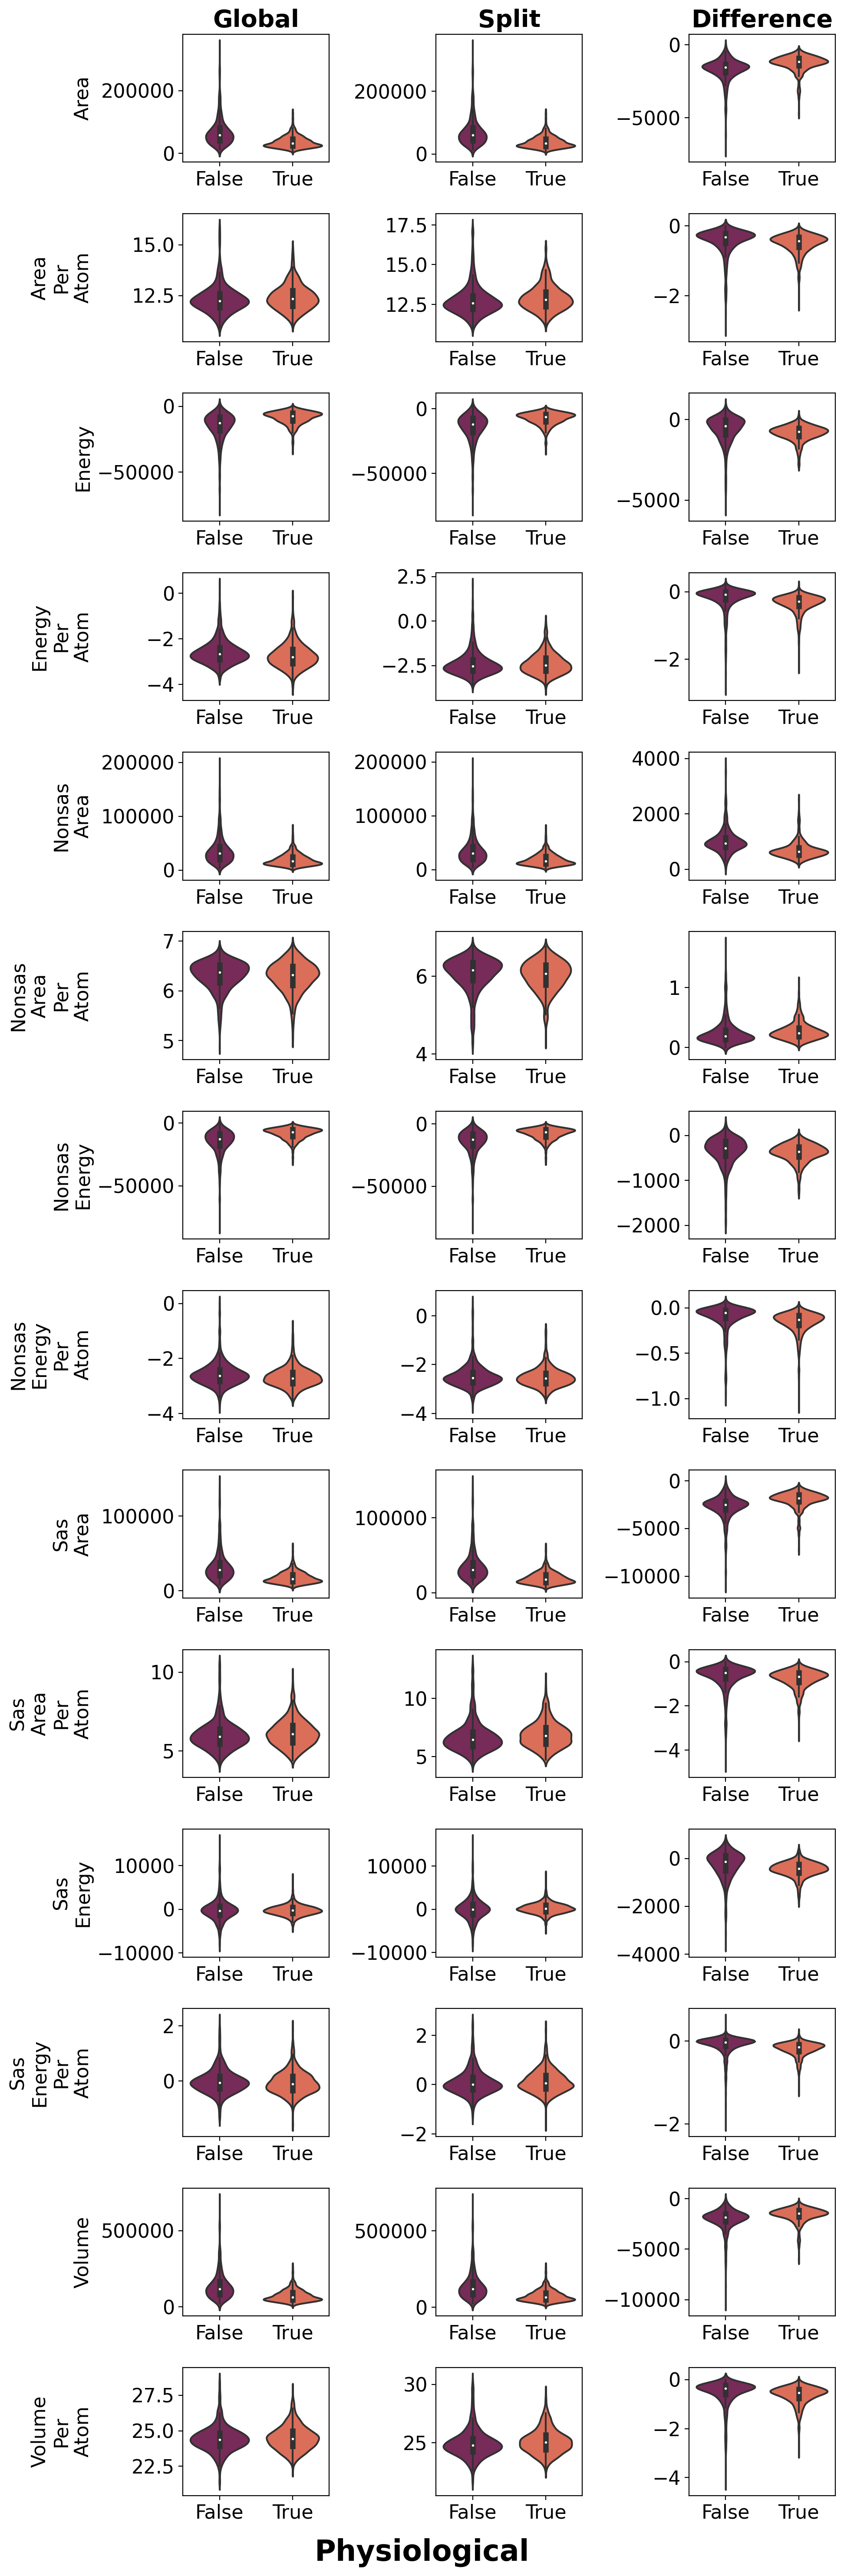

In [11]:
gl_sp_diff_features = [feature for feature in features[num_features] if feature.startswith(("global_", "difference_", "split_"))]

def sorting_key(feature):
    if len(feature.split("_")) == 2:
        return feature.split("_")[1:]
    elif feature.startswith("difference_global"):
        return feature.split("_")[2:]
    return feature.split("_")[1:]


gl_sp_diff_features = sorted(gl_sp_diff_features, key=sorting_key)
rest_features = sorted(set(num_features) - set(gl_sp_diff_features))

n_cols = 3
n_rows = int(np.ceil(len(gl_sp_diff_features) / n_cols))

fig = plt.figure(figsize=[10, 30], dpi=200)

for i, feature in enumerate(gl_sp_diff_features):
    plot = plt.subplot(n_rows, n_cols, i+1)
    sns.violinplot(data=features, y=features[feature], x=target_col, palette="rocket")
    
    
    if i // 3 == 0:
        plt.title(feature.split("_")[0].title(), fontsize=20,  weight='bold')
        
    plt.xlabel(None)
    
    if i % 3 == 0:
        plt.ylabel("\n".join(feature.split("_")[1:]).title(), fontsize=16)
    else:
        plt.ylabel(None)
    
fig.supxlabel("Physiological", fontsize=24,  weight='bold')
fig.align_labels()
plt.tight_layout();

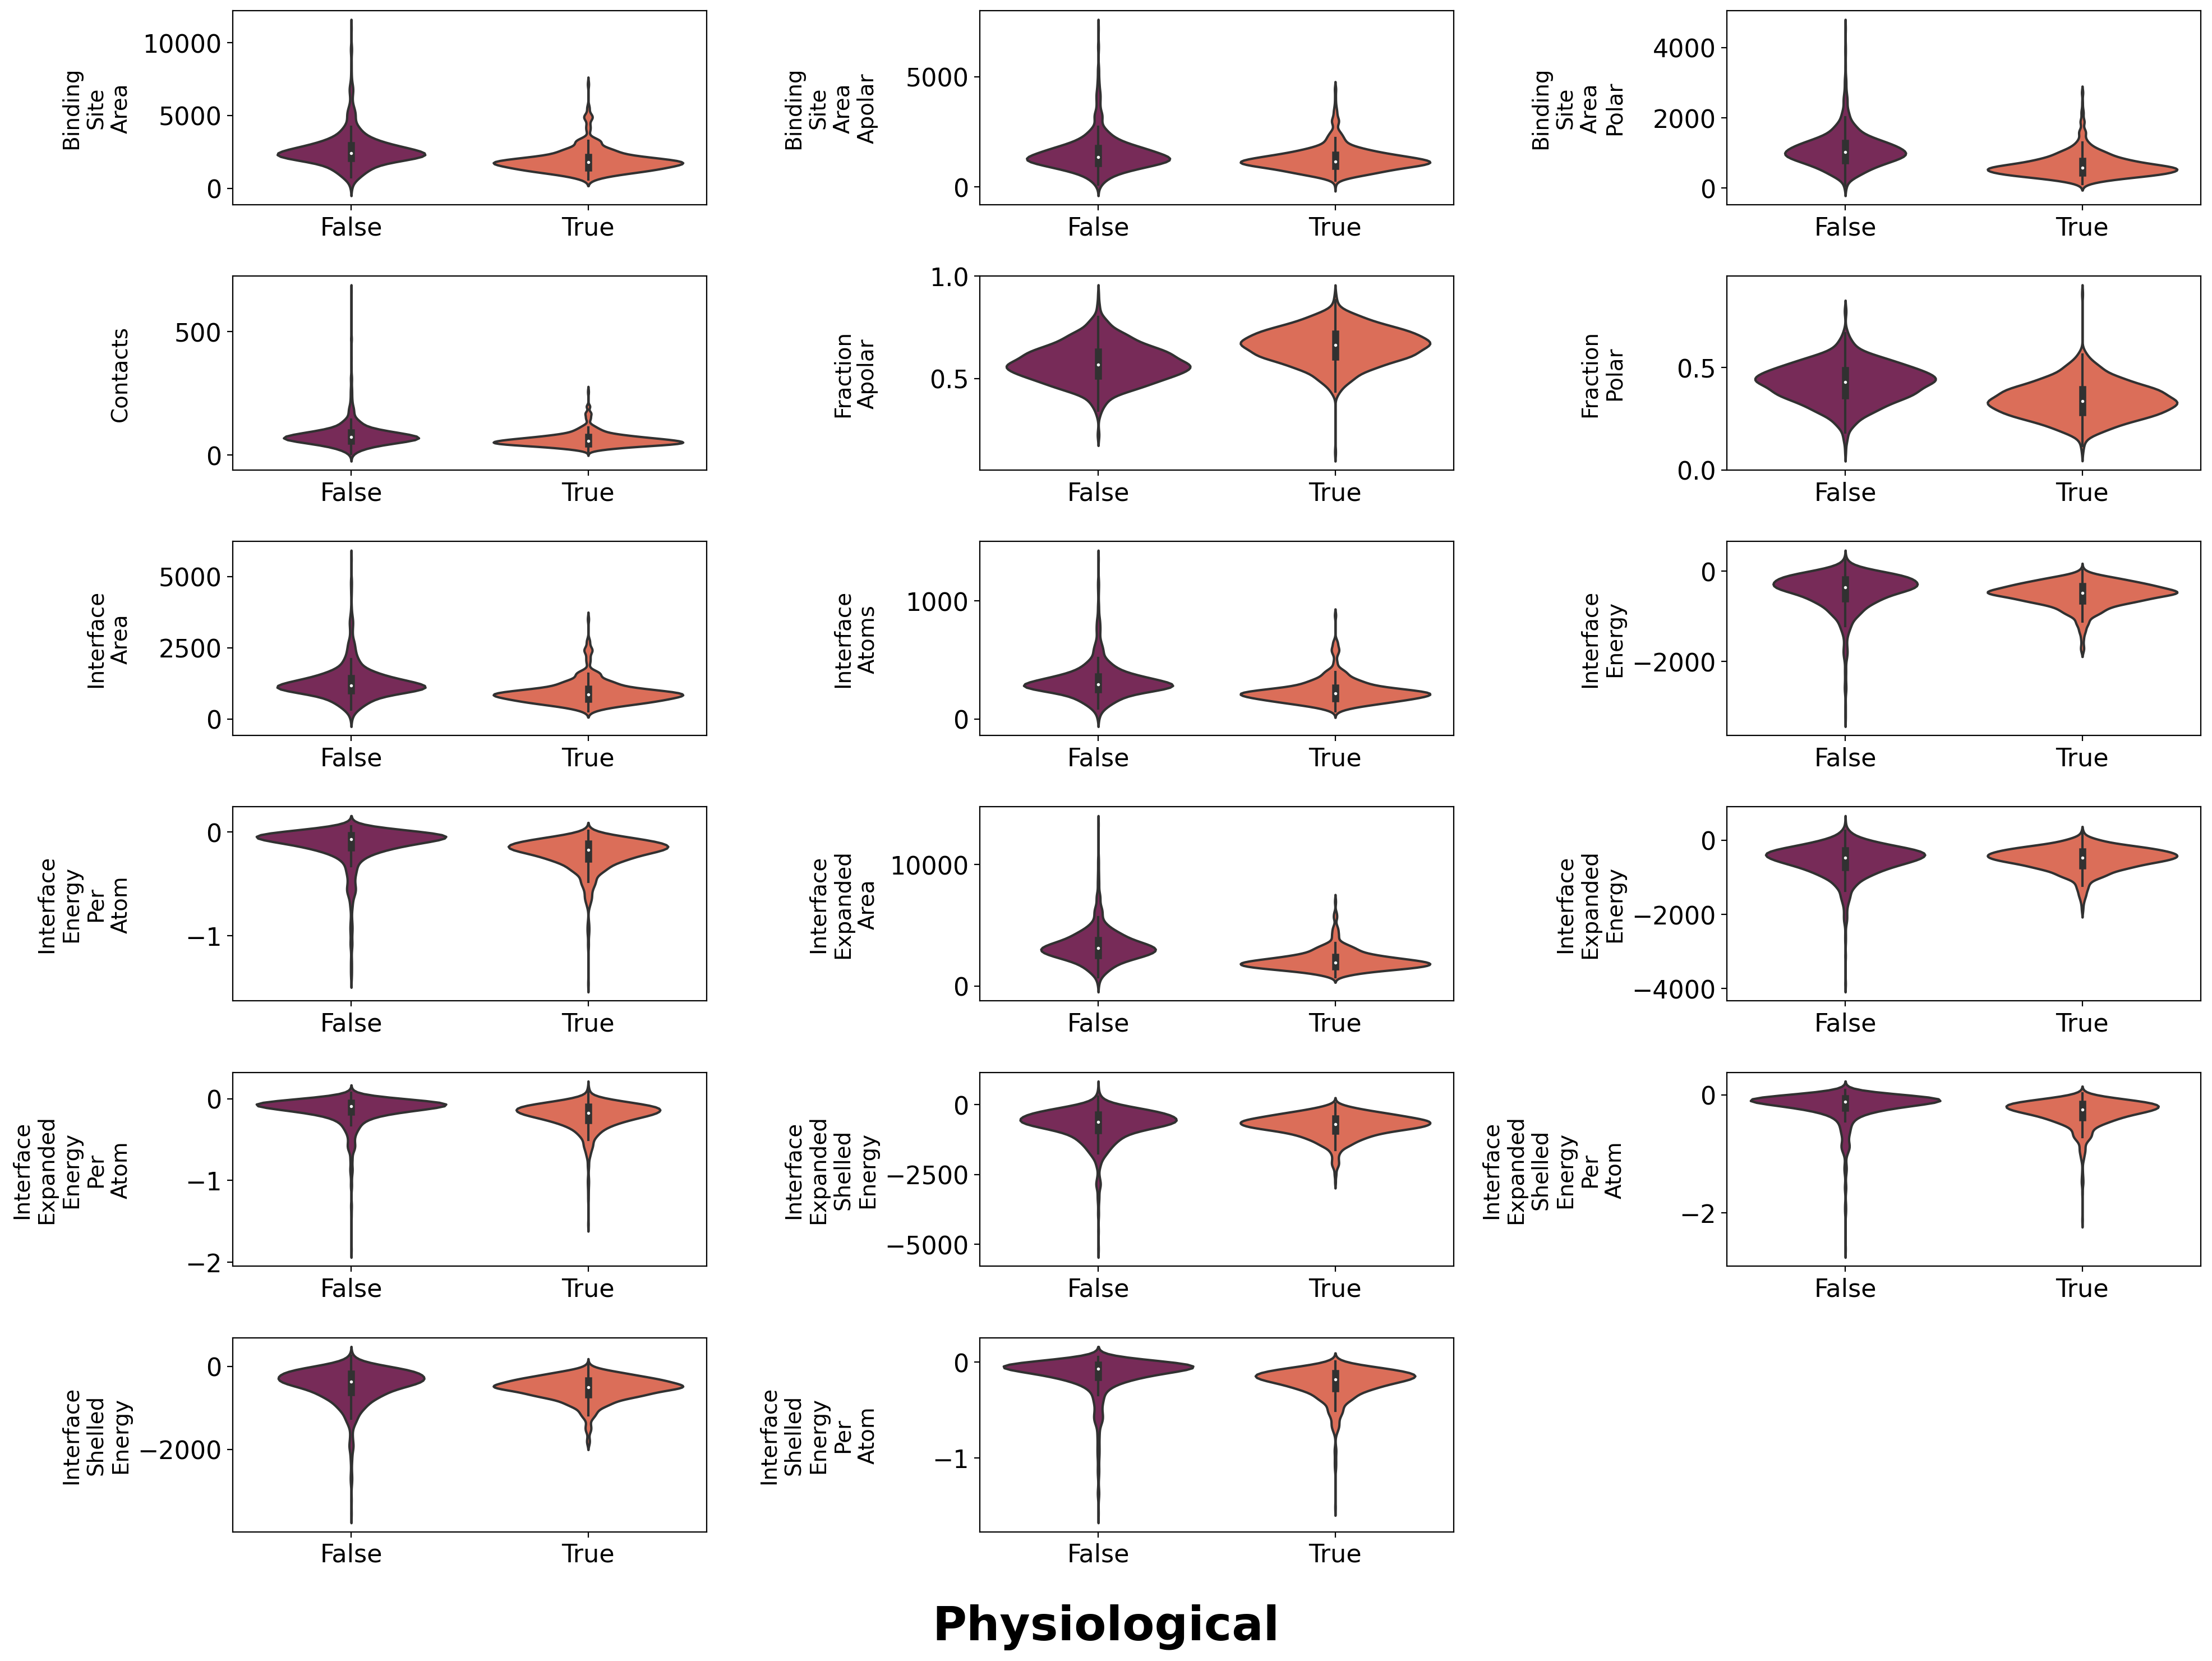

In [12]:
_cols = 3
n_rows = int(np.ceil(len(rest_features) / n_cols))

fig = plt.figure(figsize=[20, 15], dpi=200)

for i, feature in enumerate(rest_features):
    plot = plt.subplot(n_rows, n_cols, i+1)
    sns.violinplot(data=features, y=features[feature], x=target_col, palette="rocket")
        
    plt.xlabel(None)
    
    plt.ylabel("\n".join(feature.split("_")).title(), fontsize=14)

    
fig.supxlabel("Physiological", fontsize=30,  weight='bold')
fig.align_labels()
plt.tight_layout();

Давайте воспользуемся t-тестом и сравним все признаки. Данные на нормальность проверять не будем, так как у нас достаточно наблюдений, а сами распределения выглядят "примерно" нормально распределенными. Если бы мы это сделали, мы бы использовали тест Шапиро и сделали поправку на множественные сравнения. U-критерий Манна-Уитни также может служить альтернативой.

In [13]:
# t-test
t_statistic, p_value = ttest_ind(features[num_features][features[target_col]],
                                 features[num_features][~features[target_col]],
                                 equal_var=False)

# Holm-Sidak method
is_differ, adj_p_value, _, _ = multipletests(p_value, alpha=alpha)

mean_physiological = features[num_features][features[target_col]].mean()
mean_non_mean_physiological = features[num_features][~features[target_col]].mean()
mean_diff = mean_physiological - mean_non_mean_physiological


t_test_results = {
    "t_statistic": t_statistic,
    "p_value": p_value,
    "adj_p_value": adj_p_value,
    "mean_physiological": mean_physiological,
    "mean_non_physiological": mean_non_mean_physiological,
    "mean_diff": mean_diff,
    "is_differ": is_differ
}

t_test_results = pd.DataFrame(t_test_results)

In [14]:
t_test_results.query("is_differ").shape

(47, 7)

In [15]:
t_test_results.query("~is_differ")

t_statistic   p_value  adj_p_value  \
global_volume_per_atom                1.750544  0.080208     0.284254   
global_sas_energy                     0.107349  0.914529     0.989480   
global_sas_energy_per_atom           -2.165162  0.030516     0.264248   
global_nonsas_area_per_atom          -1.937450  0.052859     0.264248   
interface_expanded_energy             2.093476  0.036471     0.264248   
interface_expanded_shelled_energy    -0.953203  0.340643     0.713344   
split_energy_per_atom                 0.128927  0.897431     0.989480   
split_sas_energy                      2.169655  0.030220     0.264248   
split_sas_energy_per_atom             2.069551  0.038650     0.264248   
split_nonsas_area_per_atom           -2.654297  0.008023     0.084799   
split_nonsas_energy_per_atom         -2.139835  0.032517     0.264248   
difference_nonsas_area_per_atom       2.848042  0.004458     0.052208   

                                   mean_physiological  mean_non_physiological  \
global_volume_per_atom                      24.489732               24.415855   
global_sas_energy                         -216.610700             -226.284246   
global_sas_energy_per_atom                  -0.059988               -0.015658   
global_nonsas_area_per_atom                  6.291361                6.318824   
interface_expanded_energy                 -508.227661             -546.466697   
interface_expanded_shelled_energy         -755.391443             -731.636999   
split_energy_per_atom                       -2.398150               -2.402127   
split_sas_energy                           231.585911               26.298193   
split_sas_energy_per_atom                    0.128488                0.080499   
split_nonsas_area_per_atom                   6.018119                6.069981   
split_nonsas_energy_per_atom                -2.526638               -2.482626   
difference_nonsas_area_per_atom              0.273242                0.248843   

                                    mean_diff  is_differ  
global_volume_per_atom               0.073876      False  
global_sas_energy                    9.673546      False  
global_sas_energy_per_atom          -0.044331      False  
global_nonsas_area_per_atom         -0.027463      False  
interface_expanded_energy           38.239036      False  
interface_expanded_shelled_energy  -23.754444      False  
split_energy_per_atom                0.003976      False  
split_sas_energy                   205.287719      False  
split_sas_energy_per_atom            0.047989      False  
split_nonsas_area_per_atom          -0.051862      False  
split_nonsas_energy_per_atom        -0.044012      False  
difference_nonsas_area_per_atom      0.024399      False

In [16]:
t_test_results.query("is_differ")

t_statistic       p_value  \
global_area                                  -19.598693  5.767154e-74   
global_area_per_atom                           3.065425  2.208504e-03   
global_volume                                -19.462464  3.880078e-73   
global_energy                                 16.805440  4.097613e-57   
global_energy_per_atom                        -5.719407  1.263629e-08   
global_sas_area                              -20.579253  7.286050e-80   
global_sas_area_per_atom                       2.907064  3.696502e-03   
global_nonsas_area                           -18.542994  1.420509e-67   
global_nonsas_energy                          17.782641  5.988851e-63   
global_nonsas_energy_per_atom                 -5.351290  9.963898e-08   
interface_atoms                              -14.243642  2.878647e-43   
interface_area                               -13.544905  1.625380e-39   
interface_energy                              -4.236440  2.414525e-05   
interface_energy_per_atom                     -9.293034  4.718211e-20   
interface_shelled_energy                      -4.283569  1.961431e-05   
interface_shelled_energy_per_atom             -9.232914  8.081430e-20   
interface_expanded_area                      -21.669730  6.838949e-90   
interface_expanded_energy_per_atom            -7.100599  1.834226e-12   
interface_expanded_shelled_energy_per_atom    -8.236218  3.613996e-16   
split_area                                   -19.829825  1.724987e-75   
split_area_per_atom                            4.083201  4.655367e-05   
split_volume                                 -19.589285  5.629509e-74   
split_volume_per_atom                          3.389470  7.167559e-04   
split_energy                                  17.092232  1.013113e-58   
split_sas_area                               -21.443439  1.090264e-85   
split_sas_area_per_atom                        3.767000  1.710505e-04   
split_nonsas_area                            -18.236012  1.237219e-65   
split_nonsas_energy                           17.834416  3.262438e-63   
difference_global_area                        13.051683  5.688753e-37   
difference_global_area_per_atom               -4.635196  3.867123e-06   
difference_global_energy                      -7.416553  2.127009e-13   
difference_global_energy_per_atom             -9.703873  1.179382e-21   
difference_global_volume                       9.919239  1.673254e-22   
difference_global_volume_per_atom             -5.249635  1.738795e-07   
difference_sas_area                           14.741036  5.014419e-46   
difference_sas_area_per_atom                  -4.018584  6.139721e-05   
difference_sas_energy                         -8.900400  1.800893e-18   
difference_sas_energy_per_atom                -9.612127  2.753476e-21   
difference_nonsas_area                       -17.608404  4.040595e-63   
difference_nonsas_energy                      -3.624691  2.992495e-04   
difference_nonsas_energy_per_atom             -8.968980  8.126074e-19   
contacts                                      -9.416584  1.934724e-20   
binding_site_area                            -14.158963  8.403981e-43   
binding_site_area_polar                      -21.396402  9.198937e-89   
binding_site_area_apolar                      -7.852558  7.724785e-15   
fraction_polar                               -19.300400  4.576562e-75   
fraction_apolar                               19.913264  2.502376e-79   

                                             adj_p_value  mean_physiological  \
global_area                                 2.941248e-72        37015.469916   
global_area_per_atom                        3.047909e-02           12.408073   
global_volume                               1.940039e-71        73505.794498   
global_energy                               1.761974e-55        -8409.668476   
global_energy_per_atom                      3.159073e-07           -2.741712   
global_sas_area                             4.080188e-78   

Оказалось, что многие признаки значимо различаются между классами. По-видимому, не должно быть сложной задачей разделить эти два класса. Хорошим бейзлайном будет модель, построенная на всех числовых признаках.

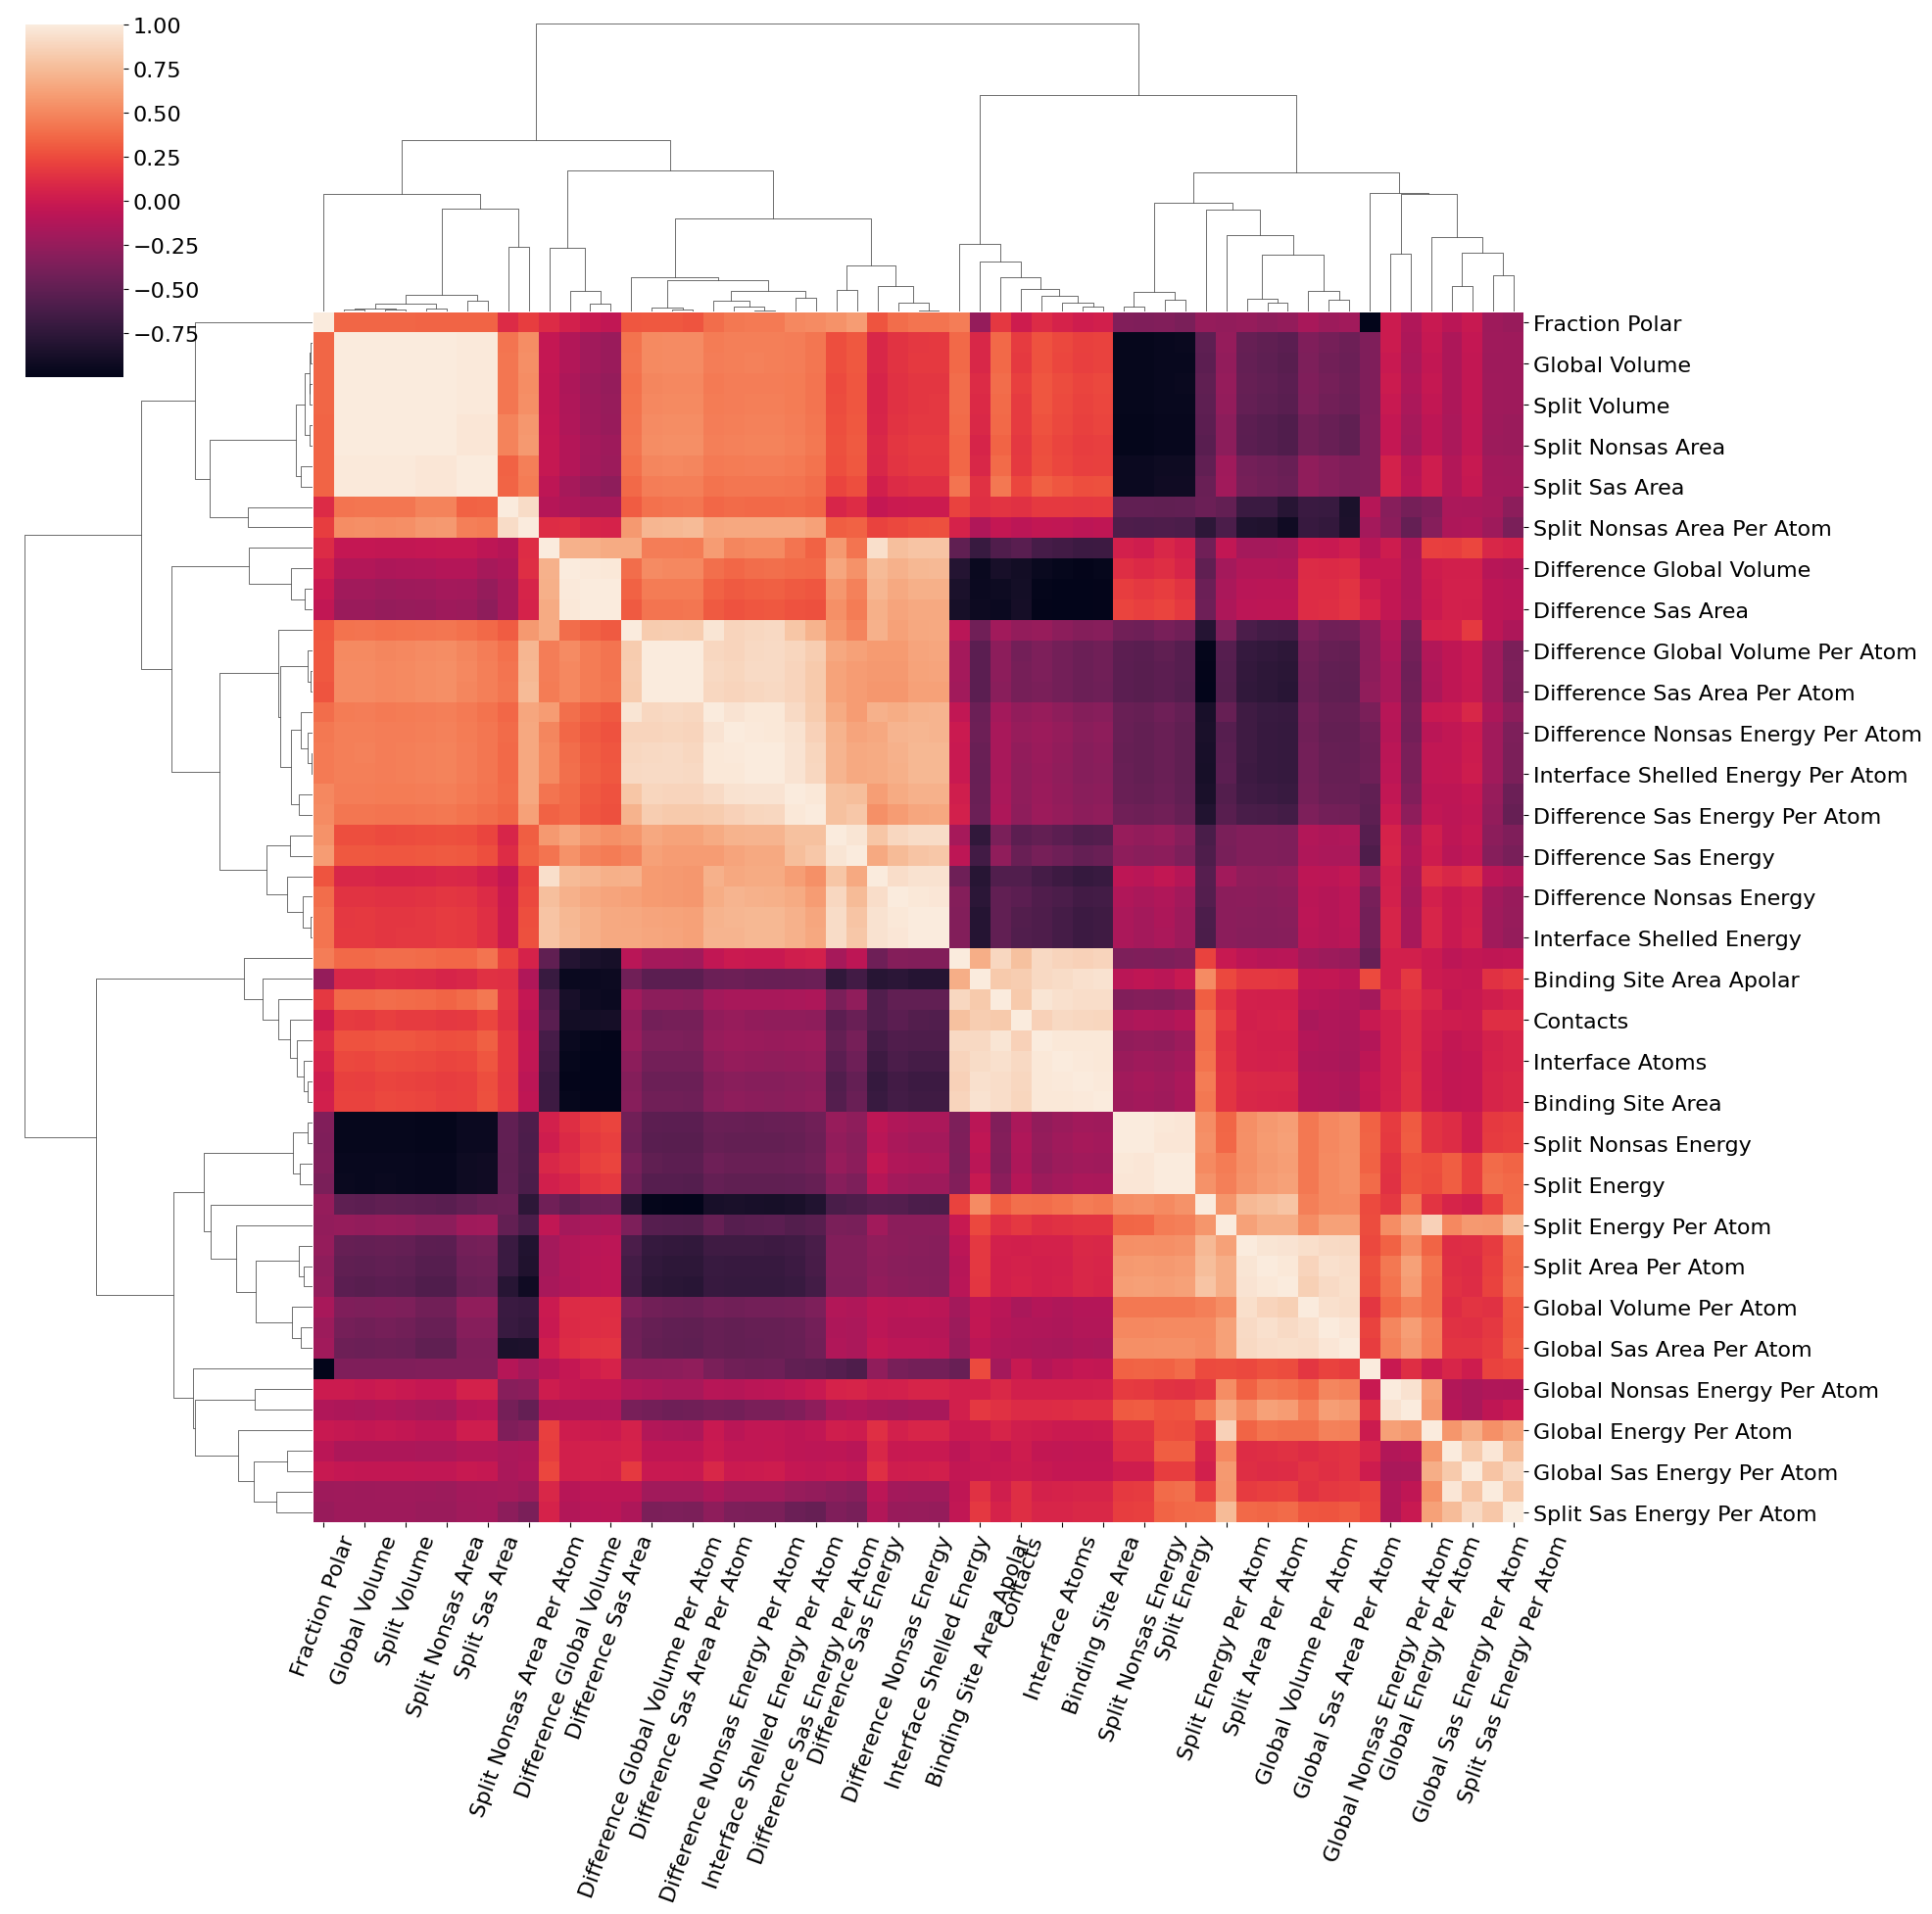

In [17]:
corr_mtx = features[num_features].corr()
corr_mtx.rename(columns={i:" ".join(i.split("_")).title() for i in corr_mtx.columns}, inplace=True)
corr_mtx.rename(index={i:" ".join(i.split("_")).title() for i in corr_mtx.index}, inplace=True)
fig = sns.clustermap(corr_mtx, figsize=(20, 20), cmap="rocket")
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_xticklabels(), rotation=70);

Интересно, что есть группы очень сильно коррелированных признаков, как положительных, так и отрицательных, возможно, мы сможем их потом убрать.

### Категориальные признаки

In [18]:
features[cat_features].nunique(), number_of_nas[number_of_nas != 0]

(pdb-id         1677
 ID             1677
 SymmetryOp1      44
 SymmetryOp2     162
 gene           1318
 superfamily     644
 pfam            945
 dtype: int64,
 SymmetryOp1    977
 SymmetryOp2    977
 gene           149
 superfamily    248
 pfam           105
 dtype: int64)

In [19]:
features[cat_features]

pdb-id      ID SymmetryOp1 SymmetryOp2          gene  \
0     1a17_6  1a17_6       1_555      15_545         PPP5C   
1     1a3a_1  1a3a_1         NaN         NaN          mtlA   
2     1a7g_1  1a7g_1         NaN         NaN            E2   
3     1ac6_1  1ac6_1         NaN         NaN      TRAV6D-7   
4     1afw_1  1afw_1         NaN         NaN          POT1   
...      ...     ...         ...         ...           ...   
1672  6vdd_2  6vdd_2       1_555       3_454          polA   
1673  6vjb_4  6vjb_4       1_555       2_756          prtS   
1674  6w25_2  6w25_2       1_555       2_758  MC4R;PAB2292   
1675  6wrh_3  6wrh_3       1_555       5_675           rep   
1676  8jdw_1  8jdw_1         NaN         NaN          GATM   

                                superfamily                     pfam  
0                                1.25.40.10                      NaN  
1                               3.40.930.10                  PF00359  
2                               3.30.70.330                  PF00511  
3                                2.60.40.10                  PF07686  
4                                3.40.47.10          PF00108;PF02803  
...                                     ...                      ...  
1672               3.30.70.370;1.20.1060.10                  PF00476  
1673                                    NaN  PF00082;PF02225;PF06280  
1674                                    NaN          PF00001;PF00534  
1675  3.10.20.540;1.10.8.1190;2.60.120.1680                  PF08715  
1676                             3.75.10.10                      NaN  

[1677 rows x 7 columns]

#### Superfamily

In [20]:
sfs_physiological = []
sfs_non_physiological = []
q = 0

for phys, sf in zip(features[target_col], features[cat_features]["superfamily"].str.split(";")):
    try:
        if phys:
            sfs_physiological += sf
        else:
            sfs_non_physiological += sf
    except TypeError:
        q += 1
        
# Check that nothing was lost
assert q == number_of_nas["superfamily"]

In [21]:
common_sfs = np.intersect1d(sfs_physiological, sfs_non_physiological)
sfs_counts = pd.DataFrame({
                "sfs_phys": len(set(sfs_physiological)),
                "sfs_non_phys": len(set(sfs_non_physiological)),
                "common_sfs": len(common_sfs)
            }, index=["count"]
            ).T
sfs_counts

count
sfs_phys        310
sfs_non_phys    566
common_sfs      132

Уже кажется, что это должна быть хорошая фича, если она правильно закодирована. Для каждого класса существует множество уникальных суперсемейств, но также интересно посмотреть, как общие семейства распределяются отдельно в каждом из классов, например, в физиологических одно семейство может встречаться часто, а в нефизиологических всего 1 раз. Для этого вычисляем доли каждого из общих семейств внутри класса, и если одна из пропорций больше (меньше) в заданное число раз (5 или 10), то сохраняем это семейство. Также можно будет сравнить распределения этих долей с помощью критерия Колмогорова-Смирнова (но с осторожностью).

In [22]:
print(len(sfs_physiological), len(sfs_non_physiological))

931 1058


In [23]:
phys_props = list(
    map(lambda x: sfs_physiological.count(x) / len(sfs_physiological), common_sfs)
)
non_phys_props = list(
    map(
        lambda x: sfs_non_physiological.count(x) / len(sfs_non_physiological),
        common_sfs,
    )
)

In [24]:
kstest(phys_props, non_phys_props)

KstestResult(statistic=0.45454545454545453, pvalue=1.1504995442499246e-12, statistic_location=0.000945179584120983, statistic_sign=-1)

In [25]:
diff_threshold = 5
for sf, p_1, p_2 in zip(common_sfs, phys_props, non_phys_props):
    if (p_1 / p_2 > diff_threshold) or (p_2 / p_1 > diff_threshold):
        print(f"{sf}\t{p_1:.4f}\t{p_2:.4f}")

1.10.510.10	0.0021	0.0180
1.10.760.10	0.0064	0.0009
2.10.60.10	0.0064	0.0009
2.30.42.10	0.0011	0.0057
2.40.50.140	0.0011	0.0066
3.10.129.10	0.0054	0.0009
3.10.450.50	0.0118	0.0009
3.10.580.10	0.0086	0.0009
3.20.20.70	0.0258	0.0047
3.30.470.20	0.0054	0.0009
3.40.30.10	0.0462	0.0057
3.40.50.170	0.0054	0.0009


Теперь нам нужно как-то векторизовать эту фичу и посмотреть, например, на кластеризацию. Есть разные способы, но возьмем относительно хороший и простой `TF-IDF`.

##### TF-IDF

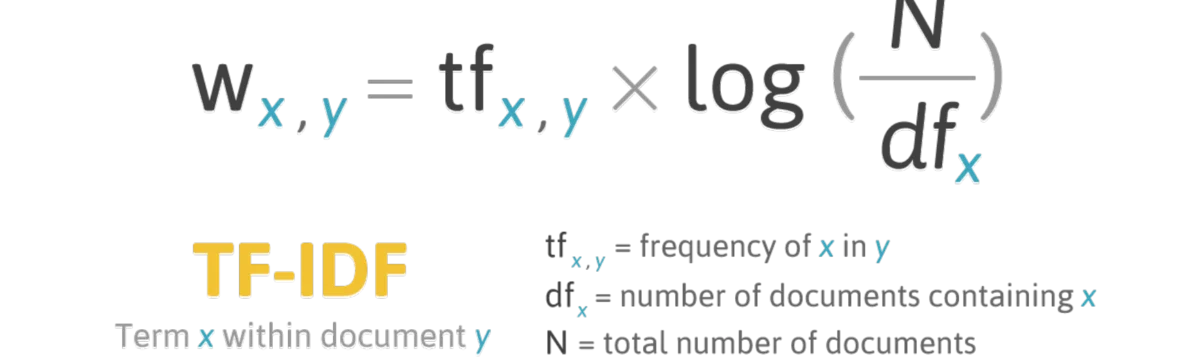

In [26]:
vectorizer = TfidfVectorizer()

In [27]:
texts = [
    "hi cat dog cat",
    "bye bird cat",
    "thanks cat danil"
]

In [28]:
vectorizer.fit_transform(texts)

<3x7 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

3 предложения (текста) и 7 уникальных слов -> матрица 3х7

In [29]:
vectorizer.fit_transform(texts).toarray()

array([[0.        , 0.        , 0.64105545, 0.        , 0.54270061,
        0.54270061, 0.        ],
       [0.65249088, 0.65249088, 0.38537163, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.38537163, 0.65249088, 0.        ,
        0.        , 0.65249088]])

In [30]:
vectorizer.vocabulary_

{'hi': 5, 'cat': 2, 'dog': 4, 'bye': 1, 'bird': 0, 'thanks': 6, 'danil': 3}

#### Продолжаем Superfamily

In [31]:
vectorizer = TfidfVectorizer()
sfs_embeddings = vectorizer.fit_transform(features["superfamily"].fillna(";").str.replace(";", " ")).toarray()
sfs_embeddings_agg = {
    "total_tfidf": sfs_embeddings.sum(axis=1),
    "max_tfidf": sfs_embeddings.max(axis=1),
    "mean_tfidf": sfs_embeddings.mean(axis=1),
}
sfs_embeddings_agg = pd.DataFrame(sfs_embeddings_agg)

In [34]:
sfs_embeddings_agg

total_tfidf  max_tfidf  mean_tfidf
0        1.540364   0.886543    0.005101
1        1.458055   0.926594    0.004828
2        1.636509   0.790769    0.005419
3        1.668069   0.775044    0.005523
4        1.396091   0.948526    0.004623
...           ...        ...         ...
1672     2.196096   0.614847    0.007272
1673     0.000000   0.000000    0.000000
1674     0.000000   0.000000    0.000000
1675     2.487657   0.534049    0.008237
1676     1.331453   0.904072    0.004409

[1677 rows x 3 columns]

In [32]:
sfs_embeddings.shape

(1677, 302)

Нет смысла использовать полученные вектора в том виде, в каком они есть. Давайте как-нибудь их агрегируем и будем использовать эти статистики как новые признаки.

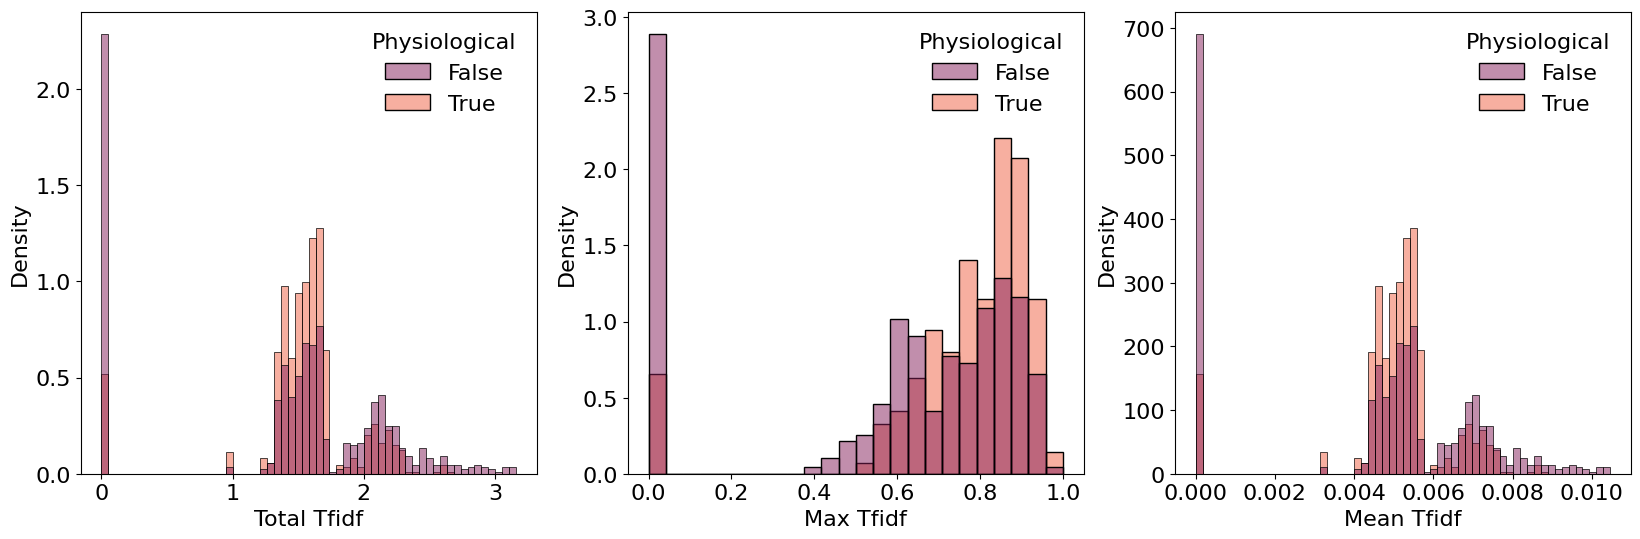

In [33]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))

for i, stat in enumerate(sfs_embeddings_agg.columns):
    sns.histplot(data=sfs_embeddings_agg, 
                 x=stat, 
                 hue=features[target_col], 
                 stat="density", 
                 ax=axes[i],
                 palette="rocket",
                 )
    legend = axes[i].get_legend()
    handles = legend.legendHandles
    legend.remove()
    axes[i].legend(handles, ["False", "True"], title='Physiological', frameon=False)
    axes[i].set_xlabel(" ".join(stat.split("_")).title())

Распределения этих статистик визуально различаются, а это значит, что можно предположить, что они могут быть важными признаками.

Теперь возьмем исходные вектора и построим на них t-SNE, чтобы посмотреть, выделяются ли какие-то кластеры.

In [35]:
sfs_tsne = TSNE(n_components=2, metric="cosine").fit(sfs_embeddings)
sfs_reduced = sfs_tsne.embedding_

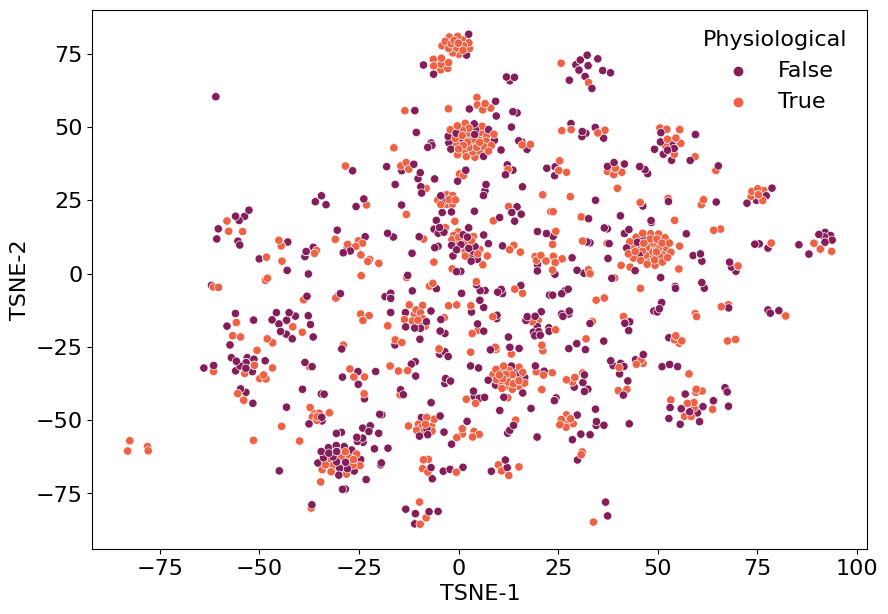

In [36]:
sns.scatterplot(x=sfs_reduced[:, 0], y=sfs_reduced[:, 1], hue=features[target_col], palette="rocket")
plt.legend(title='Physiological', frameon=False)
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2");

В 2D даже при косинусном расстоянии точки толком не разделялись на группы. Но может быть интересно проверить, осуществляется ли кластеризация через KMeans и в качестве признаков принимается расстояние точки до каждого кластера (и мы можем принять 2, например, хотя по графику t-SNE мы могли бы подумать, что кластеров гораздо больше).

In [37]:
silhouettes = []
costs = []
for i in tqdm(range(2, 30)):
    kmeans = KMeans(n_clusters=i,
                    max_iter=500,
                    n_init=10,
                    random_state=SEED)
    kmeans.fit(sfs_embeddings)
    costs.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(sfs_embeddings, kmeans.labels_))

100%|███████████████████████████████████████████| 28/28 [00:29<00:00,  1.06s/it]


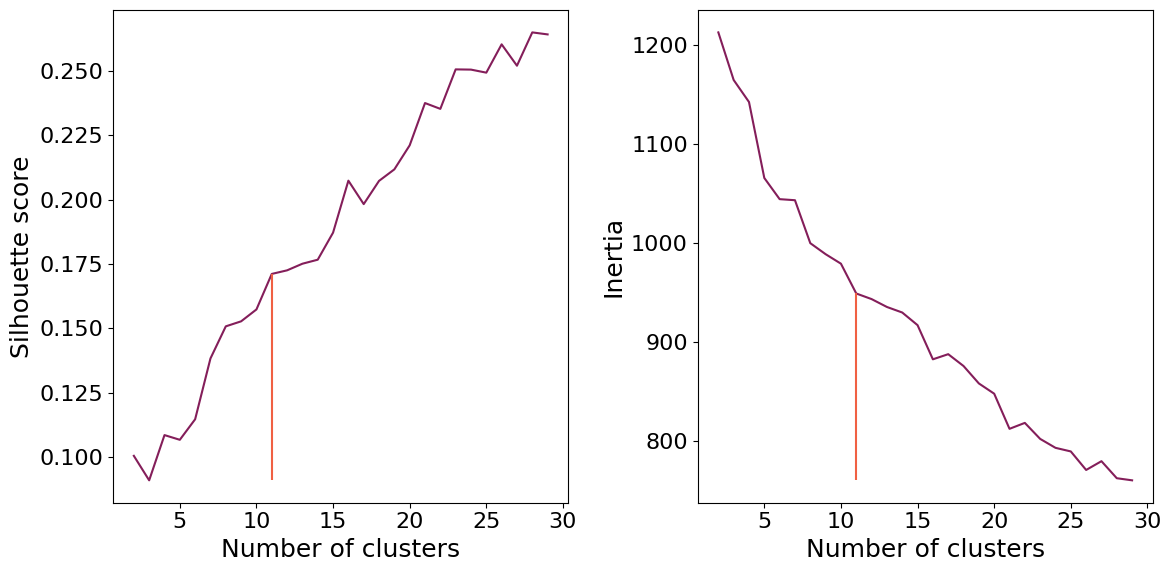

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

sns.lineplot(x=range(2, 30), y=silhouettes, ax=axes[0], color=sns.color_palette("rocket", n_colors=2)[0])
axes[0].vlines(11, min(silhouettes), silhouettes[9], color=sns.color_palette("rocket", n_colors=2)[1])
axes[0].set_ylabel("Silhouette score", fontsize=18)
axes[0].set_xlabel("Number of clusters", fontsize=18)
sns.lineplot(x=range(2, 30), y=costs, ax=axes[1], color=sns.color_palette("rocket", n_colors=2)[0])
axes[1].vlines(11, min(costs), costs[9], color=sns.color_palette("rocket", n_colors=2)[1])
axes[1].set_ylabel("Inertia", fontsize=18)
axes[1].set_xlabel("Number of clusters", fontsize=18)
plt.tight_layout();

Ярко выраженного изгиба не видно, но в целом можно предположить наличие 11 кластеров, это не так уж и много и кажется должно хватить. В конце концов, далее мы с помощью моделей проверим, важны эти признаки или нет.

In [39]:
n_clusters = 11

best_kmeans = KMeans(n_clusters=n_clusters,
                     max_iter=500,
                     n_init=10,
                     random_state=SEED)
best_kmeans.fit(sfs_embeddings)

dists_columns = [
        f"distance_to_{i}_cluster"
        for i in range(1, n_clusters + 1)
    ]
cluster_features = pd.DataFrame(
    data=best_kmeans.transform(sfs_embeddings), columns=dists_columns
) 

Мы извлекли набор признаков, которые уже сложнее интерпретировать, но в дальнейшем мы проверим, как они влияют на качество моделей.

#### PFAM

In [40]:
pfam_physiological = []
pfam_non_physiological = []
q = 0

for phys, sf in zip(features[target_col], features[cat_features]["pfam"].str.split(";")):
    try:
        if phys:
            pfam_physiological += sf
        else:
            pfam_non_physiological += sf
    except TypeError:
        q += 1
        
# Check that nothing was lost
assert q == number_of_nas["pfam"]

In [41]:
common_pfam = np.intersect1d(pfam_physiological, pfam_non_physiological)
pfam_counts = pd.DataFrame({
                "pfam_phys": len(set(pfam_physiological)),
                "pfam_non_phys": len(set(pfam_non_physiological)),
                "common_sfs": len(common_pfam)
            }, index=["count"]
            ).T
pfam_counts

count
pfam_phys        449
pfam_non_phys    811
common_sfs       119

In [42]:
print(len(pfam_physiological), len(pfam_non_physiological))

902 1199


In [43]:
phys_props = list(
    map(lambda x: pfam_physiological.count(x) / len(pfam_physiological), common_pfam)
)
non_phys_props = list(
    map(
        lambda x: pfam_non_physiological.count(x) / len(pfam_non_physiological),
        common_pfam,
    )
)

In [44]:
kstest(phys_props, non_phys_props)

KstestResult(statistic=0.5798319327731093, pvalue=7.580640418564522e-19, statistic_location=0.0008340283569641367, statistic_sign=-1)

Распределения значительно различаются, что может указывать на то, что PFAM может также являться неплохим признаком.

In [45]:
diff_threshold = 5
for sf, p_1, p_2 in zip(common_pfam, phys_props, non_phys_props):
    if (p_1 / p_2 > diff_threshold) or (p_2 / p_1 > diff_threshold):
        print(f"{sf}\t{p_1:.4f}\t{p_2:.4f}")

PF00048	0.0055	0.0008
PF00069	0.0011	0.0142
PF00072	0.0155	0.0025
PF00156	0.0044	0.0008
PF00551	0.0055	0.0008
PF00561	0.0067	0.0008
PF00571	0.0089	0.0017
PF02590	0.0044	0.0008
PF02798	0.0044	0.0008
PF07686	0.0200	0.0008
PF07714	0.0011	0.0058


In [46]:
vectorizer = TfidfVectorizer()
pfam_embeddings = vectorizer.fit_transform(features["pfam"].fillna(";").str.replace(";", " ")).toarray()
pfam_embeddings_agg = {
    "pfam_total_tfidf": pfam_embeddings.sum(axis=1),
    "pfam_max_tfidf": pfam_embeddings.max(axis=1),
    "pfam_mean_tfidf": pfam_embeddings.mean(axis=1),
}
pfam_embeddings_agg = pd.DataFrame(pfam_embeddings_agg)

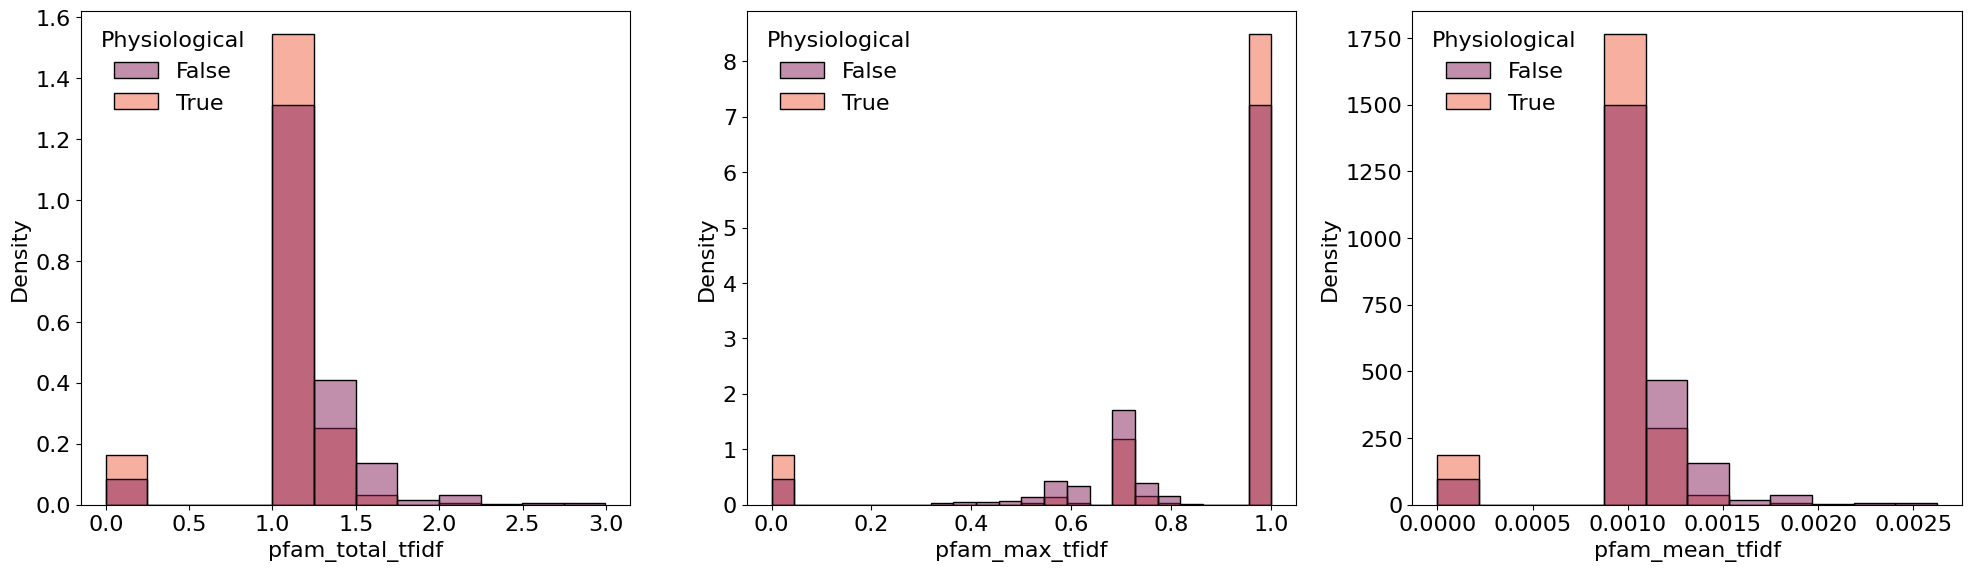

In [47]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 6))

for i, stat in enumerate(pfam_embeddings_agg.columns):
    sns.histplot(data=pfam_embeddings_agg,
                 x=stat,
                 hue=features[target_col],
                 stat="density",
                 ax=axes[i],
                 palette="rocket",
                )

    legend = axes[i].get_legend()
    handles = legend.legendHandles
    legend.remove()
    axes[i].legend(handles, ["False", "True"], title='Physiological', frameon=False, loc=2)

plt.tight_layout()

В данном случае кажется, что распределения очень похожи и вряд ли эти фичи будут полезны (но все равно можно будет проверить).

#### SymmetryOp

In [48]:
so_1_physiological = []
so_1_non_physiological = []
q = 0

for phys, sf in zip(features[target_col], features[cat_features]["SymmetryOp1"].str.split(";")):
    try:
        if phys:
            so_1_physiological += sf
        else:
            so_1_non_physiological += sf
    except TypeError:
        q += 1
        
# Check that nothing was lost
assert q == number_of_nas["SymmetryOp1"]

In [49]:
common_so_1 = np.intersect1d(so_1_physiological, so_1_non_physiological)
so_1_counts = pd.DataFrame({
                "so_1_phys": len(set(so_1_physiological)),
                "so_1_non_phys": len(set(so_1_non_physiological)),
                "common_so_1": len(common_so_1)
            }, index=["count"]
            ).T
so_1_counts

count
so_1_phys          0
so_1_non_phys     44
common_so_1        0

In [50]:
so_2_physiological = []
so_2_non_physiological = []
q = 0

for phys, sf in zip(features[target_col], features[cat_features]["SymmetryOp2"].str.split(";")):
    try:
        if phys:
            so_2_physiological += sf
        else:
            so_2_non_physiological += sf
    except TypeError:
        q += 1
        
# Check that nothing was lost
assert q == number_of_nas["SymmetryOp2"]

In [51]:
common_so_2 = np.intersect1d(so_2_physiological, so_2_non_physiological)
so_2_counts = pd.DataFrame({
                "so_2_phys": len(set(so_2_physiological)),
                "so_2_non_phys": len(set(so_2_non_physiological)),
                "common_so_2": len(common_so_2)
            }, index=["count"]
            ).T
so_2_counts

count
so_2_phys          0
so_2_non_phys    162
common_so_2        0

Интересное замечание. Можно подумать, что эта фича будет хорошей бинарной фичой (отсутствует или нет). Но это точно не тот признак, который корректно использовать для моделей. Скорее это что-то вроде утечки данных.

Также давайте посмотрим на баланс классов. Похоже, что данные сбалансированы с точки зрения целевой переменной.

In [52]:
features["physiological"].value_counts(normalize=True)

False    0.501491
True     0.498509
Name: physiological, dtype: float64

#### PDB ID

Интересно проверить, как часто у нас есть объекты с одинаковым pdb id.

In [53]:
non_unique_pdb = features["ID"].str[:4].value_counts()[(features["ID"].str[:4].value_counts() > 1)].index
non_unique_pdb = features[features["ID"].str[:4].isin(non_unique_pdb)][["ID", target_col]]
non_unique_pdb

ID  physiological
36     1dp4_1           True
37     1dp4_2           True
129    1ku2_1          False
130    1ku2_4          False
154    1nft_1          False
...       ...            ...
1624  6ii0_11          False
1625   6ii0_6          False
1626   6ii0_7          False
1629   6j09_4          False
1630   6j09_5          False

[63 rows x 2 columns]

У нас есть по существу те же самые белки в данных. Видно, что для большинства из них метки классов также совпадают. В общем, надо бы сделать так, чтобы такие объекты попадали только в одну часть данных (train или test).

Есть еще такой интересный объект. Один белок, но с разными метками классов. На них хорошо видно, как различаются признаки между классами.

In [54]:
features.loc[[214, 215]][cat_features + num_features + [target_col]]

pdb-id      ID SymmetryOp1 SymmetryOp2   gene  superfamily     pfam  \
214  1s9p_1  1s9p_1         NaN         NaN  Esrrg  1.10.565.10  PF00104   
215  1s9p_5  1s9p_5         NaN         NaN  Esrrg  1.10.565.10  PF00104   

     global_area  global_area_per_atom  global_volume  ...  \
214      42652.7              12.63784        83516.4  ...   
215      43980.6              12.74431        85867.7  ...   

     difference_nonsas_area_per_atom  difference_nonsas_energy  \
214                          0.28596                  -440.820   
215                          0.17554                  -112.183   

     difference_nonsas_energy_per_atom  contacts  binding_site_area  \
214                           -0.13061        61            2636.18   
215                           -0.03251        47            1607.28   

     binding_site_area_polar  binding_site_area_apolar  fraction_polar  \
214                  1217.04                   1419.14        0.461668   
215                   408.12                   1199.17        0.253920   

     fraction_apolar  physiological  
214         0.538332           True  
215         0.746087          False  

[2 rows x 67 columns]

In [ ]:
# GroupShuffleSplit

### Выводы

Тут можно попробовать сделать выводы про то, какие признаки потенциально будут важны и все такое. А еще можно придумать биологическую интерпретацию)

## Обучаем модели

### Валидация

Перед обучением моделей необходимо определиться с валидацией. Самый простой вариант — использовать k-fold CV (если вы не рассматриваете простое разделение train/test), но это может быть не лучшей идеей. Например, если и train, и test содержат белки одного семейства, из-за этого модель может переобучиться. Поэтому попробуем 3 разных валидации:

* K-fold
* K-fold с учетом суперсемейств
* K-fold с учетом PFAM доменов

In [55]:
class ByCategoricalFeatureSplitter(BaseCrossValidator):
    """
    ...
    """

    def __init__(
        self, cat_feature: pd.Series, n_splits: int = 5, random_state=None
    ) -> None:
        super().__init__()

        self.cat_feature = cat_feature
        self.n_splits = n_splits
        self.random_state = random_state

    def split(self, X, y=None, groups=None):
        unique_cat_feature_values = self._get_unique_feature_values()
        cat_feature_counts = self._get_cat_feature_counts()
        cat_feature_counts_sum = cat_feature_counts.sum()
        # TODO: fix bug with n_splits=1
        train_threshold = (
            cat_feature_counts_sum - cat_feature_counts_sum // self.n_splits
        )

        for i in range(self.n_splits):
            train_ids, test_ids = self._get_train_test_samples(
                cat_feature_counts, train_threshold
            )

            yield train_ids, test_ids

    def _get_unique_feature_values(self):
        unique_values = []
        for value in self.cat_feature.str.split(";")[~self.cat_feature.isna()].values:
            unique_values += value

        unique_values = list(set(unique_values))

        return unique_values

    def _get_cat_feature_counts(self):
        cat_f_expanded_df = self.cat_feature.str.split(";", expand=True)
        cat_f_counts = defaultdict(int)

        for i in range(cat_f_expanded_df.shape[1]):
            cat_f_value_counts = cat_f_expanded_df[i].value_counts()
            for val in cat_f_value_counts.index:
                cat_f_counts[val] += cat_f_value_counts[val]

        return pd.DataFrame(cat_f_counts, index=[0]).T

    def _get_train_test_samples(self, cat_feature_counts, train_threshold):
        # TODO: rewrite for loop...
        # TODO: Fix bug when by chance several cat_feature_values can
        #       fall into both subsamples. Usually it is about 30
        shuffled_cat_feature_counts = shuffle(cat_feature_counts)
        train_cat_f = set(
            shuffled_cat_feature_counts[
                (shuffled_cat_feature_counts.cumsum() < train_threshold).values
            ].index.values
        )

        cat_f_to_sample_train = defaultdict(list)
        cat_f_to_sample_test = defaultdict(list)

        for i in range(self.cat_feature.shape[0]):
            try:
                for val in self.cat_feature[i].split(";"):
                    if val in train_cat_f:
                        cat_f_to_sample_train[val].append(i)
                    else:
                        cat_f_to_sample_test[val].append(i)
                        
            except AttributeError:
                continue

        train_ids = []
        for sample in cat_f_to_sample_train.values():
            train_ids += sample
            
        test_ids = []
        for sample in cat_f_to_sample_test.values():
            test_ids += sample
        
        ambig_samples = np.intersect1d(train_ids, test_ids)
        ambig_samples = shuffle(ambig_samples)
        train_ids = np.setdiff1d(train_ids, ambig_samples)
        test_ids = np.setdiff1d(test_ids, ambig_samples)
        train_ids = train_ids.tolist()
        test_ids = test_ids.tolist()
        
        # Randomly split "ambigous samples"
        train_ids += ambig_samples[len(ambig_samples) // self.n_splits:].tolist()
        test_ids += ambig_samples[:len(ambig_samples) // self.n_splits].tolist()
        
        # Randomly split "NaN" samples
        na_samples = self.cat_feature[self.cat_feature.isna()].index
        na_samples = shuffle(na_samples)
        train_ids += na_samples[len(na_samples) // self.n_splits:].tolist()
        test_ids += na_samples[:len(na_samples) // self.n_splits].tolist()
        
        return train_ids, test_ids

    def get_n_splits(
        self, X: object = None, y: object = None, groups: object = None
    ) -> int:
        """Returns the number of splitting iterations in the cross-validator

        Args:
            X (object, optional): Always ignored, exists for compatibility. Defaults to None.
            y (object, optional): Always ignored, exists for compatibility. Defaults to None.
            groups (object, optional): Always ignored, exists for compatibility. Defaults to None.

        Returns:
            int: Returns the number of splitting iterations in the cross-validator.
        """

        return self.n_splits

In [56]:
custom_cv_sfs = ByCategoricalFeatureSplitter(cat_feature=features["superfamily"], n_splits=5)

### Baseline модель

Давайте в качестве базовой модели будем использовать Random Forest. Так как он очень быстро обучается, то мы можем попробовать провести интересный эксперимент: сделать 100 раз кросс валидацию и построить распределение среднего скора для 3-х стратегий валидации.

In [58]:
rf_model = RandomForestClassifier(n_jobs=n_jobs)

custom_cv_sfs = ByCategoricalFeatureSplitter(cat_feature=features["superfamily"], n_splits=5)
mean_cv_custom_sfs = []
custom_cv_pfam = ByCategoricalFeatureSplitter(cat_feature=features["pfam"], n_splits=5)
mean_cv_custom_pfam = []
cv = KFold()
mean_cv_kfold = []

for i in range(10): # надо 100
    cv_res = cross_validate(rf_model, features[num_features], features[target_col], cv=custom_cv_sfs, scoring="roc_auc")
    mean_cv_custom_sfs.append(cv_res["test_score"].mean())
    
    cv_res = cross_validate(rf_model, features[num_features], features[target_col], cv=custom_cv_pfam, scoring="roc_auc")
    mean_cv_custom_pfam.append(cv_res["test_score"].mean())
    
    cv_res = cross_validate(rf_model, features[num_features], features[target_col], cv=cv, scoring="roc_auc")
    mean_cv_kfold.append(cv_res["test_score"].mean())
    
mean_cv_res = {
            "mean_cv_res": mean_cv_custom_sfs + mean_cv_custom_pfam + mean_cv_kfold,
            "cv_type": ["SFS" for i in range(len(mean_cv_custom_sfs))] + ["PFAM" for i in range(len(mean_cv_custom_pfam))] + ["KFold" for i in range(len(mean_cv_kfold))]
        }
mean_cv_res = pd.DataFrame(mean_cv_res)

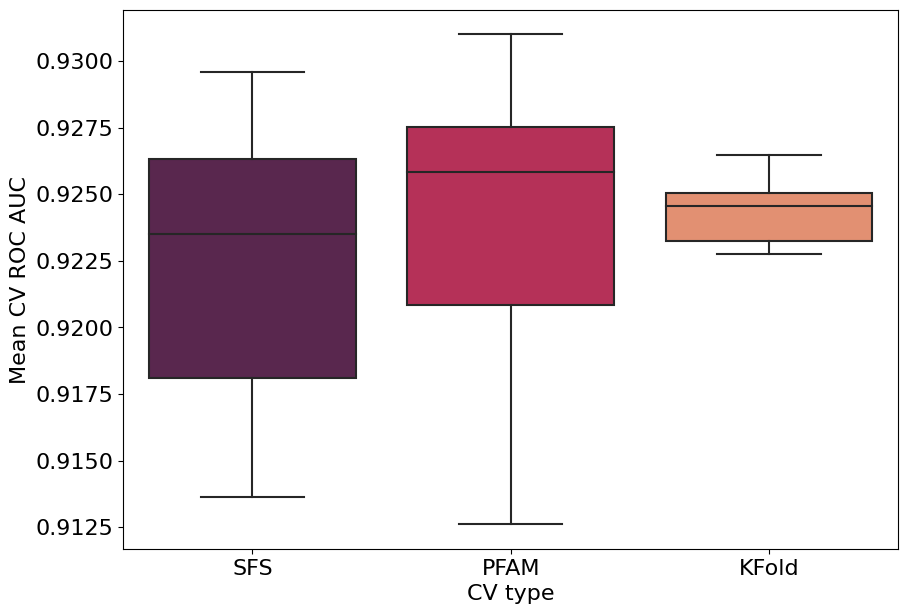

In [59]:
sns.boxplot(mean_cv_res, y="mean_cv_res", x="cv_type", palette="rocket")
plt.xlabel("CV type")
plt.ylabel("Mean CV ROC AUC");

In [60]:
ttest_ind(mean_cv_custom_sfs, mean_cv_kfold, equal_var=False)

Ttest_indResult(statistic=-1.0568060765378164, pvalue=0.31559941865963176)

In [61]:
ttest_ind(mean_cv_custom_pfam, mean_cv_kfold, equal_var=False)

Ttest_indResult(statistic=-0.10777575385947784, pvalue=0.9163471803809301)

In [62]:
cv_res = cross_validate(rf_model, features[num_features],
                        features[target_col], cv=custom_cv_sfs, scoring="roc_auc")
cv_res["test_score"].mean()

0.9217546743237219

In [63]:
cv_res = cross_validate(rf_model, features[num_features],
                        features[target_col], cv=custom_cv_pfam, scoring="roc_auc")
cv_res["test_score"].mean()

0.9281818060210535

In [64]:
cv_res = cross_validate(rf_model, features[num_features],
                        features[target_col], cv=cv, scoring="roc_auc")
cv_res["test_score"].mean()

0.9232908400353004

### Custom transformer

Давайте напишем собственный `Transformer`, чтобы мы могли извлекать категориальные признаки на тренировочных данных, а также затем преобразовывать тест, а также использовать произвольный набор признаков. Все это прекрасно интегрируется в `sklearn`.

In [65]:
class ExtractCatFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, out_features=None, extract_cluster_features=True, n_clusters=11):
        self.out_features = out_features
        self.extract_cluster_features = extract_cluster_features
        self.n_clusters = n_clusters
    
    def fit(self, X, y=None):
        X_ = deepcopy(X)
        self.sfs_vectorizer = TfidfVectorizer()
        self.pfam_vectorizer = TfidfVectorizer()
        
        sfs_embeddings = self.sfs_vectorizer.fit_transform(
            X_["superfamily"].fillna(";").str.replace(";", " ")
        ).toarray()
        self.pfam_vectorizer.fit(X["pfam"].fillna(";").str.replace(";", " "))
        
        if not self.extract_cluster_features:
            return self
        
        self.sfs_kmeans = KMeans(n_clusters=self.n_clusters, 
                                 max_iter=500, 
                                 n_init=10, 
                                 random_state=SEED)
        self.sfs_kmeans.fit(sfs_embeddings)
        
        return self
    
    def transform(self, X, y=None):
        X_ = deepcopy(X)
        # SFS
        sfs_embeddings = self.sfs_vectorizer.transform(
            X_["superfamily"].fillna(";").str.replace(";", " ")
        ).toarray()
        sfs_embeddings_agg = {
            "superfamily_total_tfidf": sfs_embeddings.sum(axis=1),
            "superfamily_max_tfidf": sfs_embeddings.max(axis=1),
            "superfamily_mean_tfidf": sfs_embeddings.mean(axis=1),
        }
        sfs_embeddings_agg = pd.DataFrame(sfs_embeddings_agg, index=X_.index)
        
        # PFAM
        pfam_embeddings = self.pfam_vectorizer.transform(
            X_["pfam"].fillna(";").str.replace(";", " ")
        ).toarray()
        pfam_embeddings_agg = {
            "pfam_total_tfidf": pfam_embeddings.sum(axis=1),
            "pfam_max_tfidf": pfam_embeddings.max(axis=1),
            "pfam_mean_tfidf": pfam_embeddings.mean(axis=1),
        }
        pfam_embeddings_agg = pd.DataFrame(pfam_embeddings_agg, index=X_.index)
        
        if not self.extract_cluster_features:
            X_ = pd.concat([X[num_features], sfs_embeddings_agg, pfam_embeddings_agg], axis=1)
            if self.out_features is None:
                out_features = X_.columns
            else:
                out_features = self.out_features
            
            return X_[out_features]
        
        dists_columns = [f"distance_to_{i}_cluster" for i in range(1, self.n_clusters + 1)]
        cluster_features = pd.DataFrame(
            data=self.sfs_kmeans.transform(sfs_embeddings), columns=dists_columns, index=X_.index
        )
        X_ = pd.concat([X[num_features], sfs_embeddings_agg, pfam_embeddings_agg, cluster_features], axis=1)
        if self.out_features is None:
            out_features = X_.columns
        else:
            out_features = self.out_features
            
        return X_[out_features]

### Lightgbm

Один из самых популярных алгоритмов работы с табличными данными. Попробуем с ним поработать: потренируемся на параметрах по умолчанию и числовых признаках, затем добавим признаки, извлеченные из категориальных переменных, выделим из них наиболее важные, а в конце подберем оптимальные гиперпараметры с помощью `Optuna`. 

#### Lightgbm. Only numerical features

In [66]:
cv = KFold(n_splits=5)
lgb_model_num = LGBMClassifier(n_jobs=n_jobs)
cv_res_lgb_model_num = cross_validate(lgb_model_num,
                                      features[num_features],
                                      features[target_col],
                                      cv=cv,
                                      scoring="roc_auc")
cv_res_lgb_model_num["test_score"].mean()

0.9284616624509692

#### Lightgbm. All features

In [67]:
cv = KFold(n_splits=5)
lgb_model_all = Pipeline([
    ("ext_cat_features", ExtractCatFeatures()),
    ("lgbm", LGBMClassifier(n_jobs=n_jobs))
])
cv_res_lgb_model_all = cross_validate(lgb_model_all,
                                      features,
                                      features[target_col],
                                      cv=cv,
                                      return_estimator=True,
                                      scoring="roc_auc")
cv_res_lgb_model_all["test_score"].mean()

0.934246955679859

#### Lightgbm. Feature selection

Методов отбора признаков существует супер много. Мы разберем лишь несколько, подробнее про них можно почитать [тут](https://github.com/danon6868/BI-ml-course/blob/main/lecture_06_feature_selection/Feature%20Selection.ipynb).

Мы попробуем наиболее простые и быстрые методы: фильтрация на основании `feature importances`, а также потом воспользуемся таким методом, как `Boruta`.

##### Feature importance from LGBM

In [68]:
ecf_trabsformer = ExtractCatFeatures().fit(features)
X_train = ecf_trabsformer.transform(features)
X_train.head()

global_area  global_area_per_atom  global_volume  global_volume_per_atom  \
0      33290.7              12.99403        63046.7                24.60839   
1      27576.3              12.20190        54497.2                24.11381   
2      16535.3              12.56482        32323.4                24.56185   
3      20742.3              12.13000        41277.9                24.13912   
4      65759.5              11.19501       133638.0                22.75077   

   global_energy  global_energy_per_atom  global_sas_area  \
0       -6364.07                -2.48402         17047.60   
1       -7467.66                -3.30427         12863.40   
2       -3276.97                -2.49010          8715.92   
3       -5331.03                -3.11756         10556.20   
4      -16828.70                -2.86495         25731.70   

   global_sas_area_per_atom  global_sas_energy  global_sas_energy_per_atom  \
0                   6.65402          -1801.530                    -0.70317   
1                   5.69177          -1617.510                    -0.71571   
2                   6.62304            371.893                     0.28259   
3                   6.17322           -802.868                    -0.46951   
4                   4.38061          -1377.680                    -0.23454   

   ...  distance_to_2_cluster  distance_to_3_cluster  distance_to_4_cluster  \
0  ...               1.042736               0.940854               1.323206   
1  ...               1.066631               0.958080               1.338088   
2  ...               1.007917               0.972282               1.400896   
3  ...               0.975488               0.913561               1.293617   
4  ...               1.092155               0.972497               1.348198   

   distance_to_5_cluster  distance_to_6_cluster  distance_to_7_cluster  \
0               0.941596               1.022394               1.200849   
1               1.010526               1.047270               1.233889   
2               1.136997               1.118762               1.297067   
3               0.879524               0.981358               1.161915   
4               1.034606               1.060089               1.248128   

   distance_to_8_cluster  distance_to_9_cluster  distance_to_10_cluster  \
0               1.278185               1.121045                1.102337   
1               1.302355               1.153441                1.178806   
2               1.347323               1.283506                1.258077   
3               0.950942               0.259359                1.105317   
4               1.309557               1.175138                1.193609   

   distance_to_11_cluster  
0                1.093180  
1                1.107989  
2                1.061115  
3                1.074651  
4                1.114015  

[5 rows x 76 columns]

In [69]:
lgb_model_fi = LGBMClassifier(n_jobs=16)
lgb_model_fi.fit(X_train, features[target_col])

LGBMClassifier(n_jobs=16)

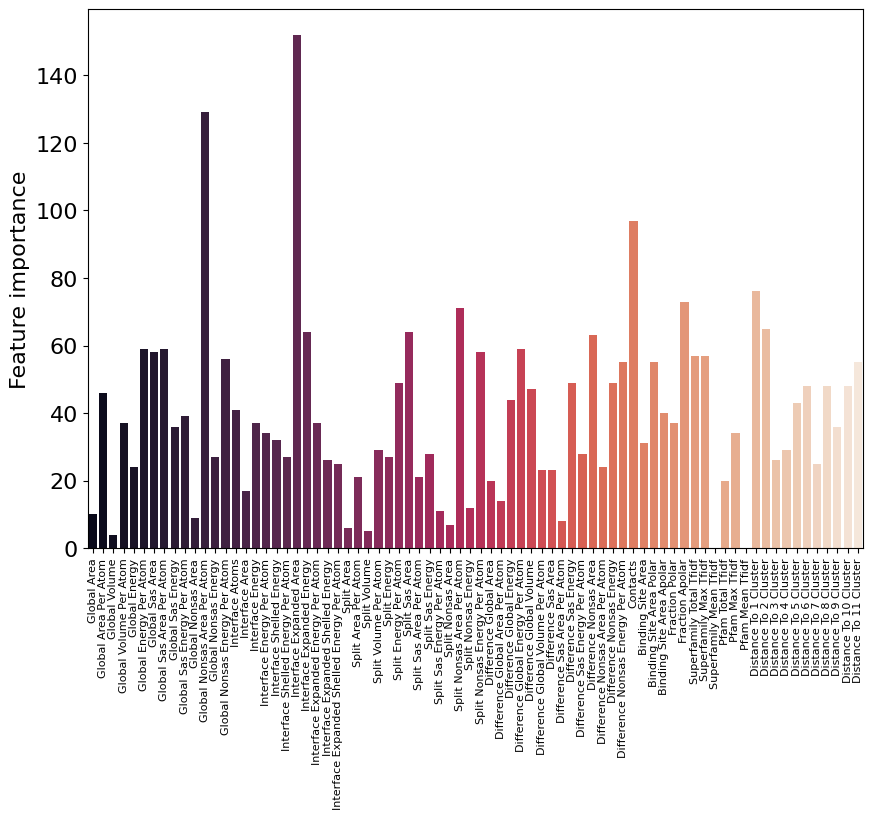

In [70]:
sns.barplot(x=[" ".join(feature.split("_")).title() for feature in lgb_model_fi.feature_name_], y=lgb_model_fi.feature_importances_, palette="rocket")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Feature importance");

In [71]:
importances = pd.DataFrame({"Importance": lgb_model_fi.feature_importances_}, 
                             index=lgb_model_fi.feature_name_) \
                                .sort_values("Importance", ascending=False)

importances.head(10)

Importance
interface_expanded_area             152
global_nonsas_area_per_atom         129
contacts                             97
distance_to_1_cluster                76
fraction_apolar                      73
split_nonsas_area_per_atom           71
distance_to_2_cluster                65
interface_expanded_energy            64
split_sas_area                       64
difference_nonsas_area               63

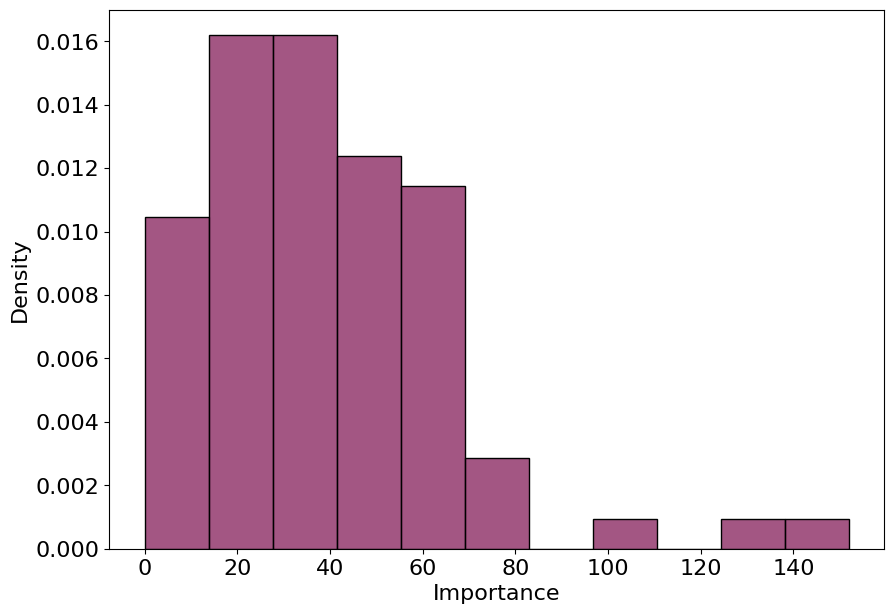

In [72]:
sns.histplot(importances["Importance"], 
             stat="density", 
             color=sns.color_palette("rocket", n_colors=2).as_hex()[0]);

Теперь можно отобрать топ-k признаков по их важности и посмотреть, как это повлияет на нашу модель.

##### [Boruta](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a)

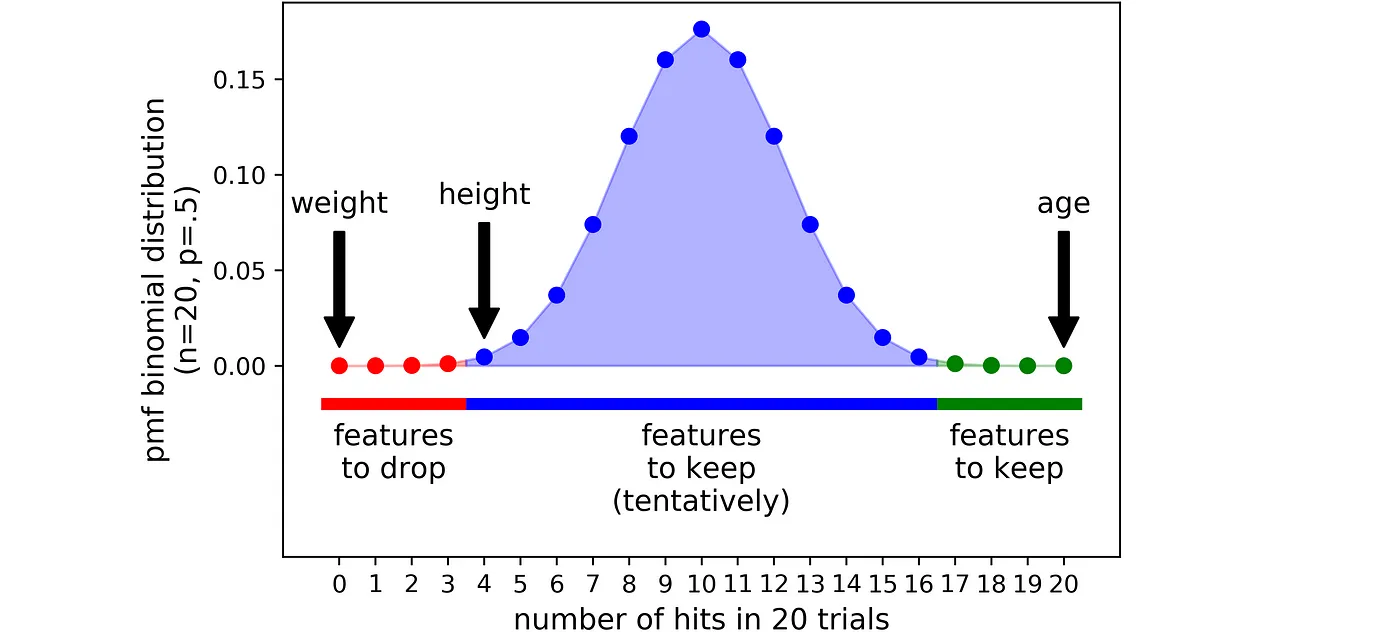

In [73]:
lgb_model = LGBMClassifier(n_jobs=16)
feature_selector = BorutaPy(lgb_model, 
                            verbose=1, 
                            random_state=SEED, 
                            perc=70, 
                            two_step=True, 
                            max_iter=10)
feature_selector.fit(X_train.values, features[target_col].values.astype(int))

clear_output()

In [74]:
selected_features = X_train.columns[feature_selector.support_].tolist()
len(selected_features)

16

In [75]:
common_top_features = np.intersect1d(selected_features, importances.index[:len(selected_features)])
print(f"{len(common_top_features)} common features between FI and Boruta")

11 common features between FI and Boruta


In [76]:
pd.DataFrame({"Selected feature": selected_features})

Selected feature
0                     global_sas_area
1         global_nonsas_area_per_atom
2                    interface_energy
3             interface_expanded_area
4                      split_sas_area
5          split_nonsas_area_per_atom
6            difference_global_energy
7   difference_global_energy_per_atom
8              difference_nonsas_area
9                            contacts
10                    fraction_apolar
11              superfamily_max_tfidf
12              distance_to_1_cluster
13              distance_to_2_cluster
14              distance_to_8_cluster
15             distance_to_11_cluster

In [77]:
pd.DataFrame({"Tentative feature": X_train.columns[feature_selector.support_weak_].tolist()})

Tentative feature
0   global_sas_area_per_atom
1             interface_area
2  interface_expanded_energy
3    binding_site_area_polar
4     distance_to_10_cluster

#### Lightgbm. HPs tunning

Для подбора гиперпараметров также суещствует множество методов, например, `GridSearch`, `RandomizedSearch` и тд, что реализовано в `sklearn`. Но с этим вы +- знакомы и эти методы имеют ряд существенных недостатков. Сегодня мы познакомимся с библиотекой `Optuna`, которая позволяет оптимизировать любую метрику для любой модели.

In [78]:
def objective(trial):
    """
    Objective function to be optimized.
    """
    param = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.005,
        "n_estimators": 1000,
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 64),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    cv = KFold(n_splits=5)
    lgb_model = Pipeline([
        ("ext_cat_features", ExtractCatFeatures(out_features=selected_features)),
        ("lgbm", LGBMClassifier(n_jobs=4, **param))
    ])
    cv_res_lgb_model = cross_validate(lgb_model,
                                      features,
                                      features[target_col],
                                      cv=cv,
                                      scoring="roc_auc")
    
    scores = cv_res_lgb_model["test_score"]
    
    return scores.mean()

In [79]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=8)

clear_output()

In [80]:
study.best_params, study.best_value

({'reg_alpha': 0.012587619114061996,
  'reg_lambda': 0.0045784222501796664,
  'num_leaves': 38,
  'feature_fraction': 0.8535722246701547,
  'bagging_fraction': 0.5805821394428738,
  'bagging_freq': 7,
  'min_child_samples': 6},
 0.9383498890391773)

In [81]:
cv = KFold(n_splits=5)
lgb_model_hp = Pipeline([
    ("ext_cat_features", ExtractCatFeatures(out_features=selected_features)),
    ("lgbm", LGBMClassifier(n_jobs=n_jobs, **study.best_params))
])
cv_res_lgb_model_hp = cross_validate(lgb_model_hp,
                                     features,
                                     features[target_col],
                                     cv=cv,
                                     return_estimator=True,
                                     scoring="roc_auc")

cv_res_lgb_model_hp["test_score"].mean()

[LightGBM] [Warning] feature_fraction is set=0.8535722246701547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8535722246701547
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5805821394428738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5805821394428738
[LightGBM] [Warning] feature_fraction is set=0.8535722246701547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8535722246701547
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5805821394428738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5805821394428738
[LightGBM] [Warning] feature_fraction is set=0.8535722246701547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8535722246701547
[LightGBM] [Warning] bagging

0.9344975748525386

#### Лучшая модель для "difficult" объектов

In [82]:
easy_proteins = features[~features["difficult"]]
difficult_proteins = features[features["difficult"]]

In [83]:
lgb_model_hp.fit(easy_proteins, easy_proteins[target_col])

[LightGBM] [Warning] feature_fraction is set=0.8535722246701547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8535722246701547
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5805821394428738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5805821394428738


Pipeline(steps=[('ext_cat_features',
                 ExtractCatFeatures(out_features=['global_sas_area',
                                                  'global_nonsas_area_per_atom',
                                                  'interface_energy',
                                                  'interface_expanded_area',
                                                  'split_sas_area',
                                                  'split_nonsas_area_per_atom',
                                                  'difference_global_energy',
                                                  'difference_global_energy_per_atom',
                                                  'difference_nonsas_area',
                                                  'contacts', 'fraction_apolar',
                                                  'superfamily_max_tfidf',
                                                  'distance_to_1_cluster',
                                                  'distance_to_2_cluster',
                                                  'distance_to_8_cluster',
                                                  'distance_to_11_cluster'])),
                ('lgbm',
                 LGBMClassifier(bagging_fraction=0.5805821394428738,
                                bagging_freq=7,
                                feature_fraction=0.8535722246701547,
                                min_child_samples=6, n_jobs=16, num_leaves=38,
                                reg_alpha=0.012587619114061996,
                                reg_lambda=0.0045784222501796664))])

In [84]:
preds_difficult = lgb_model_hp.predict(difficult_proteins)

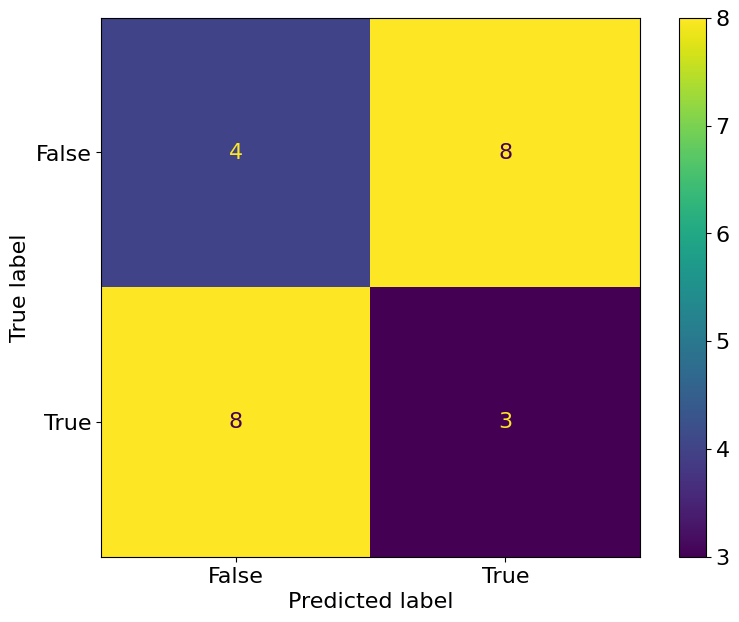

In [85]:
ConfusionMatrixDisplay.from_predictions(difficult_proteins[target_col], preds_difficult);

> Тут можно было бы еще сделать кучу всего, например, достать признаки из последовательностей или из структур, а также использовать нейронные сети, но мы с вами пока что этого не знаем, так что придется заканчивать.

# Интересности

In [86]:
single_entry = features["pdb-id"].str.endswith("_1").astype(int).to_frame()
X_train, X_test, y_train, y_test = train_test_split(single_entry, 
                                                    features[target_col], 
                                                    test_size=0.2)

rf_model = RandomForestClassifier(n_estimators=500, n_jobs=n_jobs).fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.7062721474131821

In [87]:
single_entry = features["pdb-id"].str.split("_").str[1].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(single_entry, 
                                                    features[target_col], 
                                                    test_size=0.2)

rf_model = RandomForestClassifier(n_estimators=500, n_jobs=n_jobs).fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.7469253942938153

In [88]:
# Killer feature!!!
sop_1 = features["SymmetryOp1"].isna().astype(int).to_frame()
X_train, X_test, y_train, y_test = train_test_split(sop_1, 
                                                    features[target_col], 
                                                    test_size=0.2)

rf_model = RandomForestClassifier(n_estimators=500, n_jobs=n_jobs).fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.906060606060606